# Data Exploration and Cleaning

__Project Goal__

Compare recipes from two popular recipe websites, Spoonacular and Food.com, and identify "healthy" recipes using two market-implemented measures: Nutri-Scores and Weight Watchers (WW) Smart Points. The project will investigate recipe popularity, meal types, and cuisines.

__Scope__
* Nutritional values of interest: `calories`, `saturated fat`, `sugar`, and `protein`.
* Meal types: `breakfast`, `lunch`, and `dinner`.
* Cuisines

__Research Questions__
1. Are more popular / higher-rated recipes healthier? What is the health rating of the highest-rated recipes?
2. What meal type (i.e., breakfast, lunch, or dinner) have the healthiest / unhealthiest (percentage) recipes? What is the most popular ingredient for each meal?
3. Which cuisine has the healthiest recipes?

# Setup
This section contains the library imports and functions used throughout the project.

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import scipy.stats as stats

# Import API keys
from alyssa_config import spoonacular_key, rapidapi_key
# from lakna_config import spoonacular_key

# Import functions notebook
%run functions.ipynb

# Data Exploration - Food.com

__Goal__
* Identify dataset format and required attributes.
* Extract required attributes.

__Datasets__
1. `RAW_recipes.csv`
2. `RAW_interactions.csv`

In [2]:
# Import the FOOD.COM datasets as DataFrames.
food_df = pd.read_csv('Resources/RAW_recipes.csv')
interactions_df = pd.read_csv('Resources/RAW_interactions.csv')

## Data Format and Attributes

In [3]:
# Display the DataFrame
food_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
# Display the DataFrame
interactions_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [5]:
# Get the DataFrame dimensions
interactions_shape = interactions_df.shape
food_shape = food_df.shape

# Print findings
hash = f'{8*"#"}'
print(f'{hash} Shape {hash}')
print(f"food_df: {food_shape}")
print(f"interactions_df: {interactions_shape}")

# Get the columns
print(f'\n{hash} Columns {hash}')
print(f'food_df: {food_df.columns}')
print(f'interactions_df: {interactions_df.columns}')

# Get the datatypes
print(f'\n{hash} Data Types {hash}')
print(f'food_df: {food_df.dtypes}')
print(f'\ninteractions_df: {interactions_df.dtypes}')

######## Shape ########
food_df: (231637, 12)
interactions_df: (1132367, 5)

######## Columns ########
food_df: Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')
interactions_df: Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

######## Data Types ########
food_df: name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

interactions_df: user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object


## Extract Ratings from interactions_df

In [6]:
# Check how many recipes have ratings
unique_ratings = len(interactions_df['recipe_id'].unique())

# Check how many recipes have a '0' rating
zero_rating_df = interactions_df.loc[interactions_df['rating'] == 0]['recipe_id'].unique()

# Drop the rows with a '0' rating
nonzero_df = interactions_df.loc[interactions_df['rating'] != 0]
nonzero_shape = nonzero_df.shape

# Print findings
print(f'Recipes with ratings: {unique_ratings} out of {food_shape[0]}')
print(f'Recipes with a "0" rating: {zero_rating_df.shape[0]}')
print(f'Updated shape: {nonzero_shape}')

Recipes with ratings: 231637 out of 231637
Recipes with a "0" rating: 35114
Updated shape: (1071520, 5)


In [7]:
# Create a DataFrame with the average ratings per recipe ID
food_ratings = nonzero_df.groupby('recipe_id')['rating'].mean().reset_index()

# Display the DataFrame
food_ratings.head()

,recipe_id,rating
0,38,4.250000
1,39,3.000000
2,40,4.333333
3,41,4.500000
4,43,1.000000


In [8]:
# Rename the recipe ID column for merging with food_df
food_ratings = food_ratings.rename(columns={'recipe_id': 'id'})

# Merge the datasets and display updated DataFrame
merged_food = pd.merge(food_df, food_ratings, on='id')

# Confirm the row dimensions, to ensure correct merge
merged_shape = merged_food.shape
print(f'food_ratings rows: {food_ratings.shape[0]}')
print(f'merged_food rows: {merged_shape[0]}')

# Display the DataFrame
merged_food.head()

food_ratings rows: 226590
merged_food rows: 226590


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000


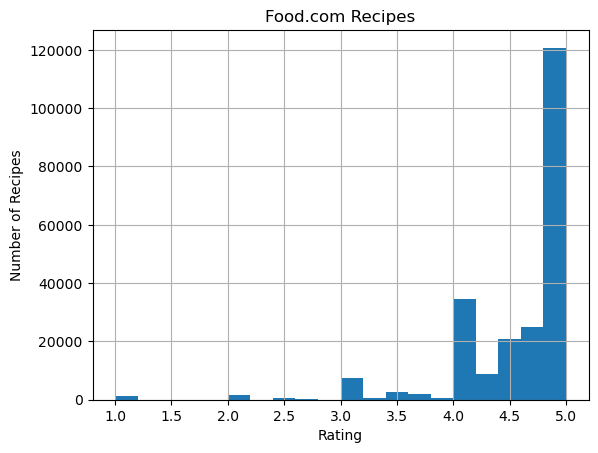

In [9]:
# Create a histogram of the ratings
merged_food['rating'].hist(bins=20)
plt.title("Food.com Recipes")
plt.xlabel("Rating")
plt.ylabel("Number of Recipes")
plt.show()

## Check for duplicate recipe IDs

In [10]:
# Determine whether there are duplicate recipes by ID
dup_id = len(merged_food['id'].unique())
print(f'Unique recipe IDs: {dup_id} of {merged_shape[0]}')

# Determine whether there are duplicate recipes by name
dup_name = len(merged_food['name'].unique())
print(f'Unique recipe names: {dup_name} of {merged_shape[0]}')

# Get the duplicate names - remove to simplify the dataset
duplicate_names = merged_food.loc[merged_food.duplicated(['name'])]
dupname_shape = duplicate_names.shape
print(f'Number of duplicate rows to remove: {dupname_shape[0]}')

# Create a new DataFrame without the duplicates
updated_food = merged_food.loc[~merged_food.duplicated(['name'])].copy()
updated_shape = updated_food.shape
print(f'updated_food rows: {updated_shape[0]}')

Unique recipe IDs: 226590 of 226590
Unique recipe names: 225190 of 226590
Number of duplicate rows to remove: 1400
updated_food rows: 225190


In [11]:
# Display the DataFrame
updated_food.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000


## Parse the `tags` column
* Extract meal types.
* Extract cuisines.

In [12]:
# Identify how to isolate each tag
tag_string = updated_food['tags'][0].strip("[]")
tag_string = tag_string.split(', ')
tag_string[0].strip("'")

# Get a list of unique tags
unique_tags = []
for string in updated_food['tags']:
    # Strip and split the string to a list
    tag_list = string.strip("[]").split(', ')
    for word_idx in range(len(tag_list)):
        # Get the tag
        tag = tag_list[word_idx].strip("'")
        if tag not in unique_tags:
            unique_tags.append(tag)

# Display the tags alphabetically
print(f"Number of unique tags: {len(unique_tags)}")
sorted(unique_tags)

Number of unique tags: 547


['',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 'breakfast-casserole

### Extract meal types
* Meal types of interest: `breakfast`, `lunch`, `dinner`

In [13]:
# Check the tags for meal types
meal_types = ["breakfast", "lunch", "dinner"]
match_meals = tag_check(meal_types)

# Print the results
print(f'Tags: {match_meals[0]}')
print(f'Not tags: {match_meals[1]}')
print(f'Alternative tags: {match_meals[2]}')

# Update the meal type list
meal_types[2] = "dinner-party"
print(f'Updated meal_types: {meal_types}')

Tags: ['breakfast', 'lunch']
Not tags: ['dinner']
Alternative tags: ['dinner-party']
Updated meal_types: ['breakfast', 'lunch', 'dinner-party']


In [14]:
# Get a count of each meal type
meal_dict = parse_tags(meal_types, 'tags', updated_food, 'id')

# Get the list of all recipes with one meal type
combined_meals = []
for key in meal_dict:
    print(f"{key}: {meal_dict[key]['count']}")
    if (key != 'multiple'):
        combined_meals.append(meal_dict[key]['id_list'])

# Flatten combined_meals
flat_meals = [index for meal_list in combined_meals for index in meal_list]

# Remove multiples to get a list of all recipes with one meal type
unique_meals = [meal for meal in flat_meals if meal not in meal_dict['multiple']['id_list']]

# Print results
print(f'Total recipes with one meal type: {len(unique_meals)}')

breakfast: 13285
lunch: 23284
dinner-party: 36690
multiple: 6839
Total recipes with one meal type: 59707


In [15]:
# Reduce the dataset to contain recipes with only one meal type
reduced_food = updated_food.loc[updated_food['id'].isin(unique_meals)].copy()
reduced_shape = reduced_food.shape

print(f'reduced_food: {reduced_shape}')
reduced_food.head()

reduced_food: (59707, 13)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,2.000000
8,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6,5.000000
9,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,4.400000


In [16]:
# Create a new column with the meal type
for key in meal_dict:
    for id in meal_dict[key]['id_list']:
        if (key == "dinner-party"):
            key = "dinner"
        reduced_food.loc[reduced_food['id'] == id, 'meal_type'] = key

# Confirm the column exists in reduced_food
reduced_food['meal_type']

1         breakfast
3            dinner
6            dinner
8             lunch
9         breakfast
            ...    
226566        lunch
226570       dinner
226573       dinner
226580       dinner
226584        lunch
Name: meal_type, Length: 59707, dtype: object

### Extract cuisines
* Spoonacular supported cuisines ([Source](https://spoonacular.com/food-api/docs#Cuisines)):

`African, Asian, American, British, Cajun, Caribbean, Chinese, Eastern European, European, French, German, Greek, Indian, Irish, Italian, Japanese, Jewish, Korean, Latin American, Mediterranean, Mexican, Middle Eastern, Nordic, Southern, Spanish, Thai, Vietnamese`

__List input__:

African
Asian
American
British
Cajun
Caribbean
Chinese
Eastern European
European
French
German
Greek
Indian
Irish
Italian
Japanese
Jewish
Korean
Latin American
Mediterranean
Mexican
Middle Eastern
Nordic
Southern
Spanish
Thai
Vietnamese

In [151]:
# Convert Spoonacular supported cuisines to a list
# input_string = input("List to pass: ")
input_string = """African American British Cajun Caribbean Chinese
    Eastern European French German Greek Indian Irish Italian
    Japanese Jewish Korean Latin American Mediterranean Mexican Middle Eastern
    Nordic Southern Spanish Thai Vietnamese"""

spoonacular_cuisines = input_string.split(' ')
spoonacular_cuisines = [word.lower() for word in spoonacular_cuisines]
spoonacular_cuisines # DOES NOT ACCOUNT FOR DOUBLE WORD.

# List comprehension to remove double words
double_words = ['eastern', 'european', 'latin', 'american', 'middle']
[spoonacular_cuisines.remove(word) for word in double_words]

# Return the two-word cuisines
spoonacular_cuisines += ['eastern european', 'latin american', 'middle eastern']
spoonacular_cuisines = sorted(spoonacular_cuisines)

In [152]:
# Check the tags for spoonacular cuisines
cuisine_match = tag_check(spoonacular_cuisines)[0]
print(f'Spoonacular Cuisines: {len(spoonacular_cuisines)}, {spoonacular_cuisines}\n')
print(f'Matched cuisines: {len(cuisine_match)}, {cuisine_match}')

Spoonacular Cuisines: 35, ['', '', '', '', '', '', '', '', '', 'african', 'american', 'british', 'cajun', 'caribbean', 'chinese\n', 'eastern\n', 'eastern european', 'french', 'german', 'greek', 'indian', 'irish', 'italian\n', 'japanese', 'jewish', 'korean', 'latin american', 'mediterranean', 'mexican', 'middle eastern', 'nordic', 'southern', 'spanish', 'thai', 'vietnamese']

Matched cuisines: 24, ['', '', '', '', '', '', '', '', '', 'african', 'american', 'cajun', 'caribbean', 'french', 'german', 'greek', 'indian', 'irish', 'japanese', 'korean', 'mexican', 'spanish', 'thai', 'vietnamese']


In [153]:
# Get a count of each cuisine
cuisine_dict = parse_tags(cuisine_match, 'tags', reduced_food, 'id')

# Get the list of all recipes with one meal type
combined_cuisines = []
for key in cuisine_dict:
    print(f"{key}: {cuisine_dict[key]['count']}")
    if (key != 'multiple'):
        combined_cuisines.append(cuisine_dict[key]['id_list'])

# Flatten combined_meals to get a list of unique recipes with one meal type
flat_cuisine = list(set([index for cuisine_list in combined_cuisines for index in cuisine_list]))

# Remove multiples to get a list of all recipes with one cuisine type
unique_cuisine = [cuisine for cuisine in flat_cuisine if cuisine not in cuisine_dict['multiple']['id_list']]
print(f'Total recipes with one cuisine type: {len(unique_cuisine)} of {reduced_food.shape[0]}')

: 0
african: 710
american: 10538
cajun: 279
caribbean: 480
french: 1092
german: 383
greek: 787
indian: 743
irish: 215
japanese: 273
korean: 66
mexican: 1661
spanish: 369
thai: 285
vietnamese: 90
multiple: 1226
Total recipes with one cuisine type: 15553 of 59707


In [154]:
# Reduce the dataset to contain recipes with only one cuisine
one_cuisine = reduced_food.loc[reduced_food['id'].isin(unique_cuisine)].copy()
print(f'one_cuisine: {one_cuisine.shape}')
one_cuisine.head()

one_cuisine: (15553, 14)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,meal_type
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667,breakfast
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,"['celery', 'onion', 'ground pork', 'soy sauce'...",7,2.000000,dinner
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,"['fresh corn', 'eggs', 'flour', 'salt', 'peppe...",8,4.666667,dinner
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,"['tomatoes', 'crackers', 'mayonnaise', 'black ...",4,5.000000,dinner
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,4.200000,lunch


In [155]:
# Create a new column with the cuisine
key_list = []
for key in cuisine_dict:
    if key != "multiple":
        key_list.append(key)
        for id in cuisine_dict[key]['id_list']:
            one_cuisine.loc[one_cuisine['id'] == id, 'cuisine'] = key

# print(key_list)
# # print(one_cuisine['cuisine'])
# #     for id in cuisine_dict[key]['id_list']:
# #         one_cuisine.loc[one_cuisine['id'] == id, 'cuisine'] = key

# # # Confirm the column exists in reduced_food
# # one_cuisine['cuisine']

# print(cuisine_dict.keys())

# thai_test = reduced_food.loc[reduced_food['id'] == 137241, 'tags']
# thai_test

# tag_check(reduced_food.loc[reduced_food['id'] == 137241, 'tags'])

# cuisine_dict['thai']['id_list']

In [156]:
one_cuisine['cuisine'].unique()

array(['american', 'indian', 'mexican', 'caribbean', 'greek', 'spanish',
       'african', 'irish', 'french', 'thai', 'german', 'vietnamese',
       'japanese', 'korean'], dtype=object)

## Convert `nutrition` column to nutritional values

__Column Contents__

calories (#), total fat (PDV), sugar (PDV), sodium (PDV) , protein (PDV), saturated fat, carbohydrates (PDV)

__Conversion Units__

* Total fat = 65g
* Sugar = 50g
* Sodium = 2400mg (2.4g)
* Protein = 50g
* Saturated fat = 20g
* Carbohydrates = 300g

__Sources__
* [Kaggle - Food.com Recipes and Interactions](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions/discussion/121778?select=RAW_recipes.csv&search=nutrition)
* [Absolute Amounts of Nutrients from Percent of Daily Values](http://krupp.wcc.hawaii.edu/biol100l/nutrition/dailyval.pdf)
* [Added Sugars on the New Nutrition Facts Label](https://www.fda.gov/food/new-nutrition-facts-label/added-sugars-new-nutrition-facts-label)

In [157]:
# Identify how to split the nutrition string and convert to float
test_string = one_cuisine['nutrition']

# Remove the square brackets
test_string = test_string[1].strip("[]")

# Split the string to a list
test_string = test_string.split(", ")

# Cast values to float
test_string = [float(value) for value in test_string]
test_string

[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]

In [158]:
# Identify how to convert PDV to nutrient quantity
conversion_ref = [65, 50, 2.4, 50, 20, 300]

# Remove 'Calories' from the test string
test_pdv = test_string[1:]

# Convert from PDV to absolute values
abs_values = []
for ref in range(len(conversion_ref)):
    abs_values.append(test_pdv[ref] * conversion_ref[ref] / 100)
abs_values

[11.7, 0.0, 0.408, 11.0, 7.0, 3.0]

In [159]:
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,meal_type,cuisine
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667,breakfast,american
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,"['celery', 'onion', 'ground pork', 'soy sauce'...",7,2.000000,dinner,american
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,"['fresh corn', 'eggs', 'flour', 'salt', 'peppe...",8,4.666667,dinner,american
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,"['tomatoes', 'crackers', 'mayonnaise', 'black ...",4,5.000000,dinner,indian
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,4.200000,lunch,mexican


In [160]:
# Parse each value in the `nutrition` column
for df_idx, row in one_cuisine.iterrows():
    # Strip and split the string to a list
    values_list = row['nutrition'].strip("[]").split(", ")

    # Allocate each nutritional value to the correct column
    for idx, value in enumerate(values_list):
        if (idx == 0):
            one_cuisine.loc[df_idx, 'Calories'] = float(value)
        elif (idx == 1):
            one_cuisine.loc[df_idx, 'Total Fat (PDV)'] = float(value)
        elif (idx == 2):
            one_cuisine.loc[df_idx, 'Sugar (PDV)'] = float(value)
        elif (idx == 3):
            one_cuisine.loc[df_idx, 'Sodium (PDV)'] = float(value)
        elif (idx == 4):
            one_cuisine.loc[df_idx, 'Protein (PDV)'] = float(value)
        elif (idx == 5):
            one_cuisine.loc[df_idx, 'Saturated Fat (PDV)'] = float(value)
        elif (idx == 6):
            one_cuisine.loc[df_idx, 'Carbohydrates (PDV)'] = float(value)

# Display the DataFrame
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,rating,meal_type,cuisine,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,4.666667,breakfast,american,173.4,18.0,0.0,17.0,22.0,35.0,1.0
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,2.000000,dinner,american,395.4,31.0,20.0,29.0,51.0,33.0,8.0
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,4.666667,dinner,american,67.1,7.0,2.0,7.0,3.0,10.0,1.0
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,5.000000,dinner,indian,3.0,0.0,1.0,0.0,0.0,0.0,0.0
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,4.200000,lunch,mexican,477.1,36.0,24.0,21.0,26.0,61.0,18.0


In [161]:
# Convert PDV nutritional values to absolute values (in grams)
merged_subset = one_cuisine[[
    'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

for df_idx, row in merged_subset.iterrows():
    for col_idx in range(len(row)):
        result = row[col_idx] * conversion_ref[col_idx] / 100
        if (col_idx == 0):
            one_cuisine.loc[df_idx, 'total_fat_g'] = result
        elif (col_idx == 1):
            one_cuisine.loc[df_idx, 'sugar_g'] = result
        elif (col_idx == 2):
            one_cuisine.loc[df_idx, 'sodium_g'] = result
        elif (col_idx == 3):
            one_cuisine.loc[df_idx, 'protein_g'] = result
        elif (col_idx == 4):
            one_cuisine.loc[df_idx, 'sat_fat_g'] = result
        elif (col_idx == 5):
            one_cuisine.loc[df_idx, 'carbs_g'] = result

# Display the DataFrame
print(f'one_cuisine: {one_cuisine.shape}')
one_cuisine.head()

one_cuisine: (15553, 28)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,17.0,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,29.0,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,7.0,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,0.0,0.0,0.0,0.0,0.00,0.5,0.000,0.0,0.0,0.0
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,21.0,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0


## Calculate WW Smart Points
* Smart Points Calculator ([Source](https://www.watcherspoint.com/weight-watchers-smart-points-calculator))
* All units (excluding calories) are in grams.

__Equation__

$$SmartPoint = (Calories * 0.0305) + (Saturated Fat * 0.275) + (Sugar * 1.2) - (Protein * 0.98)$$

In [162]:
for df_idx, row in one_cuisine.iterrows():
    calories = row.Calories
    sat_fat = row.sat_fat_g
    sugar = row.sugar_g
    protein = row.protein_g
    one_cuisine.loc[df_idx, 'wws_points'] = round((calories * 0.0305) + (sat_fat * 0.275) + (sugar * 1.2) - (protein * 0.98), 0)

# Convert wws_points to integers and display the results
one_cuisine = one_cuisine.astype({'wws_points':'int64'})
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0,-4
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0,1
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0,2
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,0.0,0.0,0.0,0.00,0.5,0.000,0.0,0.0,0.0,1
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20


## Outlier Identification

### Descriptive Statistics

In [163]:
# Check DataFrame datatypes
one_cuisine.dtypes

name                    object
id                       int64
minutes                  int64
contributor_id           int64
submitted               object
tags                    object
nutrition               object
n_steps                  int64
steps                   object
description             object
ingredients             object
n_ingredients            int64
rating                 float64
meal_type               object
cuisine                 object
Calories               float64
Total Fat (PDV)        float64
Sugar (PDV)            float64
Sodium (PDV)           float64
Protein (PDV)          float64
Saturated Fat (PDV)    float64
Carbohydrates (PDV)    float64
total_fat_g            float64
sugar_g                float64
sodium_g               float64
protein_g              float64
sat_fat_g              float64
carbs_g                float64
wws_points               int64
dtype: object

In [164]:
# Get a list of columns of type int64 and float64, excluding 'id' and 'contributor_id'
calc_cols = one_cuisine.select_dtypes(include=['int64', 'float64']).drop(columns=['id', 'contributor_id'])

# Get the descriptive statistics
calc_stats = calc_cols.describe().T.drop(columns=['count'])

# Calculate the IQR and bounds, then display the descriptive statistics
print(f'Columns with values above "max":{len(add_iqr(calc_stats))}\n{add_iqr(calc_stats)}')
calc_stats = calc_stats.T
calc_stats

Columns with values above "max":17
['minutes', 'n_steps', 'n_ingredients', 'Calories', 'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)', 'total_fat_g', 'sugar_g', 'sodium_g', 'protein_g', 'sat_fat_g', 'carbs_g', 'wws_points']


,minutes,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
mean,96.166206,10.509805,9.445830,4.601278,468.275979,37.790909,70.018324,29.134315,36.940333,48.403459,13.743394,24.564091,35.009162,0.699224,18.470167,9.680692,41.230181,40.855591
std,895.723023,6.586589,3.960604,0.603556,658.013764,63.421818,230.674464,66.652473,54.481330,93.906455,27.721680,41.224182,115.337232,1.599659,27.240665,18.781291,83.165041,152.800622
min,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-896.000000
25%,20.000000,6.000000,7.000000,4.400000,190.400000,10.000000,8.000000,6.000000,8.000000,9.000000,3.000000,6.500000,4.000000,0.144000,4.000000,1.800000,9.000000,1.000000
50%,35.000000,9.000000,9.000000,4.875000,332.400000,24.000000,21.000000,16.000000,22.000000,26.000000,8.000000,15.600000,10.500000,0.384000,11.000000,5.200000,24.000000,11.000000
75%,65.000000,13.000000,12.000000,5.000000,536.700000,45.000000,59.000000,34.000000,53.000000,59.000000,15.000000,29.250000,29.500000,0.816000,26.500000,11.800000,45.000000,36.000000
max,64815.000000,113.000000,37.000000,5.000000,13598.200000,2255.000000,8781.000000,2369.000000,2638.000000,4610.000000,816.000000,1465.750000,4390.500000,56.856000,1319.000000,922.000000,2448.000000,5610.000000
iqr,45.000000,7.000000,5.000000,0.600000,346.300000,35.000000,51.000000,28.000000,45.000000,50.000000,12.000000,22.750000,25.500000,0.672000,22.500000,10.000000,36.000000,35.000000
lower_bounds,-47.500000,-4.500000,-0.500000,3.500000,-329.050000,-42.500000,-68.500000,-36.000000,-59.500000,-66.000000,-15.000000,-27.625000,-34.250000,-0.864000,-29.750000,-13.200000,-45.000000,-51.500000
upper_bounds,132.500000,23.500000,19.500000,5.900000,1056.150000,97.500000,135.500000,76.000000,120.500000,134.000000,33.000000,63.375000,67.750000,1.824000,60.250000,26.800000,99.000000,88.500000


### Column: ~ (PDV)

#### Explore outliers

In [165]:
# Get upper_bounds for PDV columns
upper_pdv = calc_stats.loc['upper_bounds', ['Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

# Create a dictionary to hold the count and IDs
pdv_dict = {}
for col in upper_pdv.index:
    pdv_dict[col] = dict(count = 0, id_list = [])

# Loop through upper_pdv to get the count and IDs
for idx, value in enumerate(upper_pdv):
    col_name = upper_pdv.index[idx]
    pdv_dict[col_name]['count'] = one_cuisine.loc[one_cuisine[col_name] > value, 'id'].count()
    pdv_dict[col_name]['id_list'] = one_cuisine.loc[one_cuisine[col_name] > value, 'id']

# Get the list of all recipes which exceeds upper bounds for PDV
combined_pdv = []
for key in pdv_dict:
    print(f"{key}: {pdv_dict[key]['count']}")
    combined_pdv.append(pdv_dict[key]['id_list'])

# Flatten combined_pdv
flat_pdv = list(set([index for pdv_list in combined_pdv for index in pdv_list]))
print(f'Total recipes which exceed upper bounds for PDV: {len(flat_pdv)}')

Total Fat (PDV): 958
Sugar (PDV): 1697
Sodium (PDV): 1025
Protein (PDV): 615
Saturated Fat (PDV): 934
Carbohydrates (PDV): 865
Total recipes which exceed upper bounds for PDV: 3398


In [166]:
# Explore values outlier values
outside_pdv = one_cuisine.loc[one_cuisine['id'].isin(flat_pdv)]
outside_pdv.sort_values(by='wws_points', ascending=False).head()

# Although PDV correlates to a single serving, the outliers identified are not reasonable.
# This also corresponds to very high WW Smart Points, which is not realistic.
# This could be attributed to errors in inputing serving sizes for the recipe.

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
221527,white holiday punch,16495,40,59780,2001-12-31,"['60-minutes-or-less', 'time-to-make', 'course...","[13598.2, 579.0, 8781.0, 168.0, 280.0, 1153.0,...",6,"['mix sugar and water in a saucepan', 'stir co...",a wonderfully sweet holiday punch with just a ...,...,280.0,1153.0,816.0,376.35,4390.5,4.032,140.0,230.6,2448.0,5610
223153,woolfes candied dills,32198,2890,40047,2002-06-25,"['weeknight', 'time-to-make', 'course', 'main-...","[6812.1, 7.0, 6730.0, 1224.0, 29.0, 5.0, 568.0]",9,['drain the pickles and half or quarter them l...,years ago these were in the markets. now there...,...,29.0,5.0,568.0,4.55,3365.0,29.376,14.5,1.0,1704.0,4232
221212,white chocolate cake with strawberry filling,252102,45,25455,2007-09-11,"['60-minutes-or-less', 'time-to-make', 'course...","[11083.0, 666.0, 5541.0, 200.0, 155.0, 1344.0,...",25,"['for cake: preheat oven to 350f', 'grease and...",from paula deen's holiday baking (2007). time...,...,155.0,1344.0,586.0,432.90,2770.5,4.800,77.5,268.8,1758.0,3661
219114,walnut baklava,68193,40,54716,2003-08-04,"['60-minutes-or-less', 'time-to-make', 'course...","[12176.2, 886.0, 5322.0, 206.0, 247.0, 922.0, ...",17,"['mix together the walnuts , sugar and cinnamo...",NaN,...,247.0,922.0,582.0,575.90,2661.0,4.944,123.5,184.4,1746.0,3494
23603,black bean amanatto candied black beans,305674,180,56061,2008-05-28,"['time-to-make', 'course', 'main-ingredient', ...","[5630.3, 3.0, 5195.0, 100.0, 80.0, 3.0, 469.0]",24,"['rinse beans , picking out any stones or odd ...",this is a simplified version of amanatto. whi...,...,80.0,3.0,469.0,1.95,2597.5,2.400,40.0,0.6,1407.0,3250


#### Recipes with very high PDV

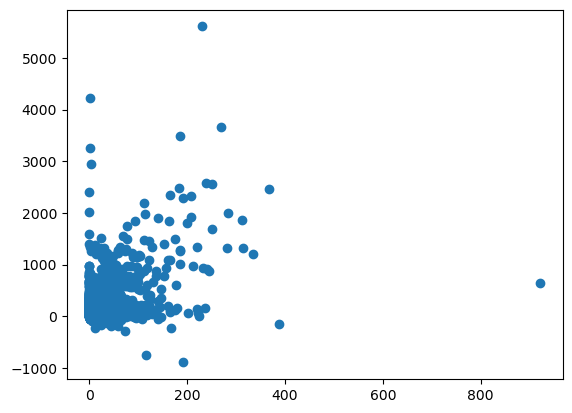

In [167]:
# UNHEALTHY RECIPES - PDV well outside the range
x_values = outside_pdv['sat_fat_g']
y_values = outside_pdv['wws_points']
fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
# ax.set_xlabel(

In [168]:
within_pdv = one_cuisine.loc[~one_cuisine['id'].isin(flat_pdv)].copy()
print(f'within_pdv: {within_pdv.shape}')
within_pdv.head()

within_pdv: (12155, 29)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0,-4
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0,1
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0,2
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,0.0,0.0,0.0,0.00,0.5,0.000,0.0,0.0,0.0,1
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20


### Column: 'minutes'

#### Explore outliers

In [169]:
# Identify recipes with '0' minutes cooking time
zeromin_recipes = within_pdv.loc[within_pdv['minutes'] == 0]
print(f'zeromin_recipes: {zeromin_recipes.shape}')
zeromin_recipes.sort_values(by='minutes', ascending=False)

zeromin_recipes: (27, 29)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
13072,baked artichoke and spinach dip,4345,0,1562,1999-11-11,"['15-minutes-or-less', 'time-to-make', 'course...","[39.3, 3.0, 2.0, 3.0, 4.0, 6.0, 0.0]",7,"['combine mayonnaise , sour cream , parmesan c...",NaN,...,4.0,6.0,0.0,1.95,1.0,0.072,2.0,1.2,0.0,1
117048,large vegetable and cheese strata,5377,0,1564,1999-12-15,"['15-minutes-or-less', 'time-to-make', 'course...","[332.0, 36.0, 13.0, 16.0, 40.0, 55.0, 3.0]",10,"['assembly', 'in a large skillet saute the oni...",NaN,...,40.0,55.0,3.0,23.40,6.5,0.384,20.0,11.0,9.0,1
203686,tammi rodriguez s secret garden fresh salsa,5417,0,2004,1999-12-13,"['15-minutes-or-less', 'time-to-make', 'course...","[76.8, 1.0, 39.0, 1.0, 7.0, 0.0, 5.0]",2,['put all items in blender and chop for 30-60 ...,authentic recipe from old mexico. passed down ...,...,7.0,0.0,5.0,0.65,19.5,0.024,3.5,0.0,15.0,22
181954,shrimp stir fry ii,4948,0,1534,1999-12-01,"['15-minutes-or-less', 'time-to-make', 'course...","[171.3, 11.0, 10.0, 28.0, 39.0, 19.0, 2.0]",7,"['in large frying pan at medium-high heat , me...",NaN,...,39.0,19.0,2.0,7.15,5.0,0.672,19.5,3.8,6.0,-7
181945,shrimp spring rolls goi cuon,4770,0,1533,1999-11-21,"['15-minutes-or-less', 'time-to-make', 'course...","[18.2, 0.0, 1.0, 1.0, 5.0, 0.0, 0.0]",10,['soak noodles in hot water for 15 to 20 mins ...,NaN,...,5.0,0.0,0.0,0.00,0.5,0.024,2.5,0.0,0.0,-1
161932,praline pecan crunch,4846,0,1533,1999-11-23,"['15-minutes-or-less', 'time-to-make', 'course...","[451.8, 34.0, 93.0, 13.0, 14.0, 13.0, 20.0]",12,"['heat oven to 250 f', 'combine cereal and pec...",NaN,...,14.0,13.0,20.0,22.10,46.5,0.312,7.0,2.6,60.0,63
161228,potato pancakes german style,4247,0,1544,1999-11-11,"['15-minutes-or-less', 'time-to-make', 'course...","[259.1, 4.0, 11.0, 20.0, 18.0, 4.0, 16.0]",9,['keep potatoes covered with cold water until ...,NaN,...,18.0,4.0,16.0,2.60,5.5,0.480,9.0,0.8,48.0,6
157754,pizza pleasure bread,5283,0,1952,1999-12-05,"['15-minutes-or-less', 'time-to-make', 'course...","[207.4, 11.0, 10.0, 21.0, 15.0, 15.0, 9.0]",3,"['use stick pepperoni and dice into 1 / 4"" chu...",i have made this for the girls at work and the...,...,15.0,15.0,9.0,7.15,5.0,0.504,7.5,3.0,27.0,6
155929,pickled pigs feet,4860,0,1655,1999-11-24,"['15-minutes-or-less', 'time-to-make', 'course...","[87.4, 0.0, 9.0, 0.0, 1.0, 0.0, 2.0]",8,"[""wash pig's feet well"", 'cover with cold , sa...",NaN,...,1.0,0.0,2.0,0.00,4.5,0.000,0.5,0.0,6.0,8
143438,okonomiyaki japanese pizza,4608,0,1556,1999-11-16,"['15-minutes-or-less', 'time-to-make', 'course...","[326.9, 25.0, 24.0, 17.0, 15.0, 13.0, 11.0]",21,['toast the nori by waving it over a flame unt...,i'm told that this is authentic and that it is...,...,15.0,13.0,11.0,16.25,12.0,0.408,7.5,2.6,33.0,18


In [170]:
# Get the upper bounds value from the 'minutes' column
minutes_upper = calc_stats.loc['upper_bounds', 'minutes']

# Identify recipes with very long cooking times
long_recipes = within_pdv.loc[within_pdv['minutes'] > minutes_upper]
print(f'long_recipes: {long_recipes.shape}')
long_recipes.sort_values(by='minutes', ascending=False)

long_recipes: (928, 29)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
83008,flavored vinegar,479702,64815,1195537,2012-05-21,"['time-to-make', 'course', 'cuisine', 'prepara...","[15.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,"['collect the number of bottles necessary , wi...","adapted from the book ""the french farmhouse ki...",...,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0
133590,mint oil,72352,20160,6357,2003-10-02,"['weeknight', 'time-to-make', 'course', 'cuisi...","[7.7, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",6,"['add oil to the pounded mint leaves , a littl...","from the foodcourt column, weekend magazine.",...,0.0,0.0,0.0,0.65,0.0,0.000,0.0,0.0,0.0,0
128207,marinated stuffed cherry peppers,81105,20160,31150,2004-01-14,"['time-to-make', 'course', 'main-ingredient', ...","[376.3, 61.0, 5.0, 2.0, 3.0, 24.0, 0.0]",20,"['wash cherry peppers and place whole , stems ...",i originally found this recipe here on recipez...,...,3.0,24.0,0.0,39.65,2.5,0.048,1.5,4.8,0.0,14
208368,thor s pickled wienies hot dogs,194697,10095,278084,2006-11-09,"['time-to-make', 'course', 'main-ingredient', ...","[197.6, 26.0, 8.0, 27.0, 13.0, 33.0, 1.0]",9,['cut the garlic cloves into 3 or 4 large slic...,"these are so addictive. thor remembered a ""be...",...,13.0,33.0,1.0,16.90,4.0,0.648,6.5,6.6,3.0,6
35511,caribbean ginger beer,504961,10090,163112,2013-07-30,"['time-to-make', 'course', 'main-ingredient', ...","[82.3, 0.0, 80.0, 0.0, 0.0, 0.0, 7.0]",11,"['wash and scrape the skin off the ginger', 'g...",this is not 'beer' as most think of it. there...,...,0.0,0.0,7.0,0.00,40.0,0.000,0.0,0.0,21.0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134000,mixed grain and wild rice cereal,58810,135,37449,2003-04-08,"['weeknight', 'time-to-make', 'course', 'main-...","[223.7, 3.0, 86.0, 0.0, 9.0, 5.0, 16.0]",9,"['preheat oven to 375', 'grease a 2 1 / 2 quar...",i got this off the internet. i have been looki...,...,9.0,5.0,16.0,1.95,43.0,0.000,4.5,1.0,48.0,54
152170,peanut butter pretzel truffles,448470,135,1105991,2011-02-09,"['time-to-make', 'course', 'main-ingredient', ...","[142.4, 14.0, 22.0, 3.0, 8.0, 14.0, 4.0]",10,['combine peanut butter and pretzels in a smal...,this is from eating well magazine. i haven't ...,...,8.0,14.0,4.0,9.10,11.0,0.072,4.0,2.8,12.0,14
21138,belgian hare a la maryland,277247,135,64642,2008-01-07,"['time-to-make', 'course', 'main-ingredient', ...","[258.4, 21.0, 3.0, 5.0, 13.0, 40.0, 8.0]",6,"['preheat oven to 325f', 'place butter in an u...",rabbit is available at supermarkets these days...,...,13.0,40.0,8.0,13.65,1.5,0.120,6.5,8.0,24.0,6
189593,spanish chicken with vegetables and olives p...,483466,135,1706426,2012-07-16,"['time-to-make', 'main-ingredient', 'cuisine',...","[717.2, 77.0, 16.0, 42.0, 110.0, 85.0, 2.0]",9,"['preheat oven to 375', 'truss your chicken', ...",chilindron fefers to combining smoked ham wit...,...,110.0,85.0,2.0,50.05,8.0,1.008,55.0,17.0,6.0,-18


#### Long Recipes

In [171]:
# How many of the long recipes had PDV outliers?
pdv_long = one_cuisine.loc[one_cuisine['id'].isin(flat_pdv)]
pdv_long.sort_values(by='minutes', ascending=False)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
8331,armenian basterma dried cured beef,21584,47520,29203,2002-03-05,"['weeknight', 'time-to-make', 'course', 'main-...","[5.3, 0.0, 0.0, 102.0, 0.0, 0.0, 0.0]",12,['select very tender cut of beef from rib part...,this is armenian cured spiced beef. it is a wo...,...,0.0,0.0,0.0,0.00,0.0,2.448,0.0,0.0,0.0,0
162096,preserved fresh lemons,209590,43230,242729,2007-02-06,"['time-to-make', 'course', 'main-ingredient', ...","[223.1, 7.0, 64.0, 2019.0, 13.0, 3.0, 21.0]",17,"['soak the lemons in water for 2 to 3 days , c...",i always have at least one jar of preserved le...,...,13.0,3.0,21.0,4.55,32.0,48.456,6.5,0.6,63.0,39
307,apple pie,124853,43200,213699,2005-06-06,"['time-to-make', 'course', 'main-ingredient', ...","[285.8, 0.0, 281.0, 0.0, 0.0, 0.0, 24.0]",2,['mix ingredence together except everclear and...,a home made alcohalic drink it take 1 month fo...,...,0.0,0.0,24.0,0.00,140.5,0.000,0.0,0.0,72.0,177
80986,favorite amish cinnamon bread,197469,14460,343789,2006-11-24,"['time-to-make', 'course', 'cuisine', 'prepara...","[4361.2, 208.0, 1915.0, 112.0, 111.0, 135.0, 2...",16,"['on day 1: combine 1 cup milk , 1 cup sugar ,...",i got this from my mom and as it was passed fr...,...,111.0,135.0,246.0,135.20,957.5,2.688,55.5,27.0,738.0,1235
116021,koolickles,367788,10085,79877,2009-04-25,"['time-to-make', 'course', 'main-ingredient', ...","[2167.2, 6.0, 2133.0, 1222.0, 28.0, 5.0, 182.0]",6,['drain the liquid from the pickles into a lar...,make up a jar and keep them in your fridge. s...,...,28.0,5.0,182.0,3.90,1066.5,29.328,14.0,1.0,546.0,1332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108548,indian chili chicken with onions,34058,0,23302,2002-07-15,"['15-minutes-or-less', 'time-to-make', 'course...","[1019.5, 122.0, 67.0, 90.0, 81.0, 71.0, 13.0]",17,"['heat oil in a wok', 'put in onions and fry u...",this is supposedly very similar to the chicken...,...,81.0,71.0,13.0,79.30,33.5,2.160,40.5,14.2,39.0,36
144844,onion flowers with pecans,2785,0,1573,1999-08-23,"['15-minutes-or-less', 'time-to-make', 'course...","[847.3, 103.0, 106.0, 17.0, 19.0, 155.0, 20.0]",15,"['preheat oven to 350 degrees', 'peel the onio...",NaN,...,19.0,155.0,20.0,66.95,53.0,0.408,9.5,31.0,60.0,89
92283,gorditas,1649,0,1534,1999-09-29,"['15-minutes-or-less', 'time-to-make', 'course...","[1018.6, 132.0, 3.0, 104.0, 32.0, 176.0, 15.0]",9,"['fry beef and onion together', 'season with s...",NaN,...,32.0,176.0,15.0,85.80,1.5,2.496,16.0,35.2,45.0,27
105531,honey taffy,16744,0,14386,2002-01-05,"['15-minutes-or-less', 'time-to-make', 'course...","[1425.2, 51.0, 1170.0, 6.0, 4.0, 103.0, 98.0]",8,"['combine ingredients in large , heavy saucepa...",how about an old fashioned taffy pull?fun for ...,...,4.0,103.0,98.0,33.15,585.0,0.144,2.0,20.6,294.0,749


In [172]:
pdv_mins = pdv_long.loc[pdv_long['minutes'] > minutes_upper]
print(f'Recipes with PDV outliers: {pdv_long.shape[0]}')
print(f'Long recipes with PDV outliers: {pdv_mins.shape[0]}')

Recipes with PDV outliers: 3398
Long recipes with PDV outliers: 506


In [173]:
# How many of the long recipes are highly rated?
best_long = long_recipes.loc[long_recipes['rating'] == 5].copy()
best_long['minutes'].describe()

count      431.000000
mean       740.088167
std       3528.181956
min        135.000000
25%        160.500000
50%        225.000000
75%        417.500000
max      64815.000000
Name: minutes, dtype: float64

#### Remove Outliers in 'minutes' column

In [174]:
# Remove recipes greater than the calculated upper bounds AND recipes with '0' minutes cooking time
clean_recipes = within_pdv.loc[(within_pdv['minutes'] < minutes_upper) & (within_pdv['minutes'] > 0)].copy()
print(f'clean_recipes: {clean_recipes.shape}')
clean_recipes.head()

clean_recipes: (11200, 29)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0,-4
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0,1
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0,2
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,0.0,0.0,0.0,0.00,0.5,0.000,0.0,0.0,0.0,1
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20


### Column: 'wws_points'

#### Explore outliers

In [175]:
# Get the descriptive statistics summary
clean_descript = clean_recipes['wws_points'].describe()
clean_descript

count    11200.000000
mean        13.911786
std         22.775922
min        -44.000000
25%          0.750000
50%          8.000000
75%         22.000000
max         99.000000
Name: wws_points, dtype: float64

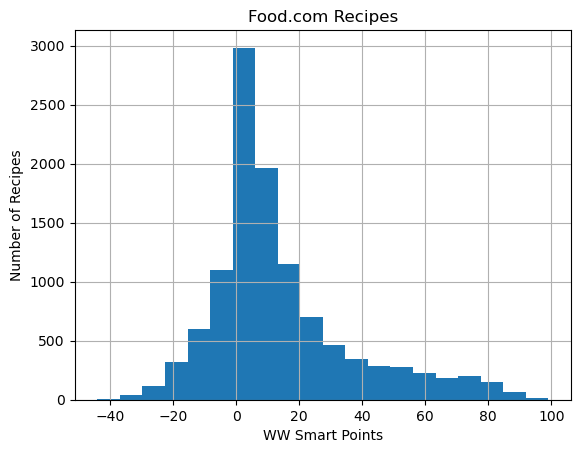

In [176]:
# Create a histogram of the points
clean_recipes['wws_points'].hist(bins=20)
plt.title("Food.com Recipes")
plt.xlabel("WW Smart Points")
plt.ylabel("Number of Recipes")
plt.show()

ShapiroResult(statistic=0.9042231440544128, pvalue=3.4877041515616396e-17)

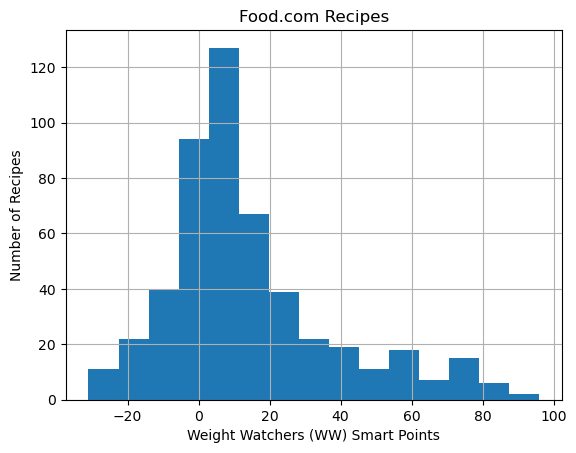

In [177]:
# Check for Gaussian distribution - using Shapiro-Wilk test
# Note: Shapiro-Wilk is sensitive to sample size
sample_set = clean_recipes['wws_points'].sample(n=500)
sample_set.hist(bins=15)
plt.title("Food.com Recipes")
plt.xlabel("Weight Watchers (WW) Smart Points")
plt.ylabel("Number of Recipes")

stats.shapiro(sample_set)
# A very high W-statistic suggests a good fit to a normal distribution.
# A near-zero p-value, for a Shapiro-Wilk test, rejects the null hypothesis, meaning NOT a normal distribution.

#### Investigate whether removing outliers results in a Normal Distribution
* Result: Higher W-statistic, slightly better p-value but still near-zero.

In [178]:
# Get clean_recipes['wws_points'] outliers
points_outliers = add_iqr(clean_descript)
points_outliers

count           11200.000000
mean               13.911786
std                22.775922
min               -44.000000
25%                 0.750000
50%                 8.000000
75%                22.000000
max                99.000000
iqr                21.250000
lower_bounds      -31.125000
upper_bounds       53.875000
dtype: float64

ShapiroResult(statistic=0.9641166925430298, pvalue=1.0655908377898982e-09)

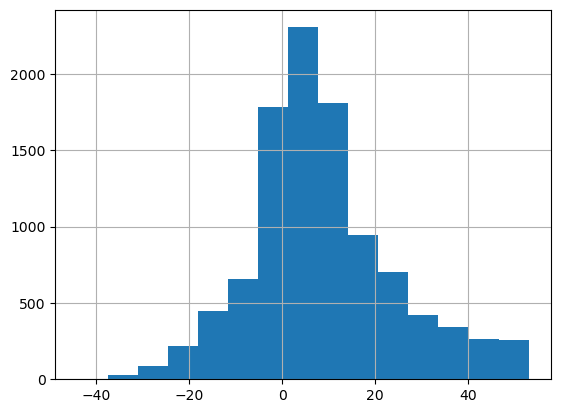

In [179]:
clean_recipes1 = clean_recipes.loc[clean_recipes['wws_points'] < points_outliers.upper_bounds]
clean_recipes1['wws_points'].hist(bins=15)

sample_set1 = clean_recipes1['wws_points'].sample(n=500)
stats.shapiro(sample_set1)
# Removing outliers creates in a higher W-statistic, however the p-value is still near-zero.

## Nutritional Values Correlation

In [180]:
pdv_cut = clean_recipes[['rating', 'Calories', 'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

corr_matrix = round(pdv_cut.corr(), 2)
corr_matrix

corr_matrix.style.background_gradient(cmap='Blues')

,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
rating,1.000000,0.020000,0.040000,0.020000,0.020000,-0.010000,0.030000,-0.010000
Calories,0.020000,1.000000,0.860000,0.130000,0.570000,0.730000,0.720000,0.590000
Total Fat (PDV),0.040000,0.860000,1.000000,-0.020000,0.470000,0.570000,0.850000,0.200000
Sugar (PDV),0.020000,0.130000,-0.020000,1.000000,-0.090000,-0.130000,-0.010000,0.420000
Sodium (PDV),0.020000,0.570000,0.470000,-0.090000,1.000000,0.530000,0.420000,0.310000
Protein (PDV),-0.010000,0.730000,0.570000,-0.130000,0.530000,1.000000,0.470000,0.190000
Saturated Fat (PDV),0.030000,0.720000,0.850000,-0.010000,0.420000,0.470000,1.000000,0.150000
Carbohydrates (PDV),-0.010000,0.590000,0.200000,0.420000,0.310000,0.190000,0.150000,1.000000


## Initial Visualisation

### Meal Types

In [324]:
# Isolate 'breakfast, lunch, dinner' from clean_recipes
meal_df = clean_recipes.groupby(['meal_type']).mean(numeric_only=True)
meal_df = meal_df.drop(columns=['id', 'contributor_id'])
meal_df

,minutes,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
meal_type,,,,,,,,,,,,,,,,,,
breakfast,34.218673,9.929361,8.501843,4.602346,307.870639,24.731572,31.104423,18.845209,23.894963,32.546683,9.015971,16.075522,15.552211,0.452285,11.947482,6.509337,27.047912,18.127764
dinner,41.013367,10.159302,9.451958,4.611259,293.784038,23.647901,28.868218,16.647901,26.938670,29.593961,7.416889,15.371135,14.434109,0.399550,13.469335,5.918792,22.250668,14.716308
lunch,32.915344,9.166822,9.079676,4.598230,317.298195,23.845316,23.902894,22.116402,31.456894,28.529101,8.989107,15.499455,11.951447,0.530794,15.728447,5.705820,26.967320,10.183318


In [325]:
# Bin by `wws_points` then groupby each meal type
min_points = clean_recipes['wws_points'].describe().min()
max_points = clean_recipes['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points+16, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
points_labels = [f'{points_bins[i]} to {points_bins[i+1]}' for i in range(len(points_bins)-1)]
bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins, labels=points_labels)

# Set the index and its name
points_df = clean_recipes.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges', 'meal_type']).median(numeric_only=True) # originally mean
binned_df

id  minutes  contributor_id  n_steps  \
WWS Point Ranges meal_type                                               
-28.0 to -12.0   breakfast  159095.0     35.0         88099.0     10.0   
                 dinner     157657.0     40.0         86764.0     10.0   
                 lunch      186627.0     30.0        162826.0      9.0   
-12.0 to 4.0     breakfast  224262.5     25.0        166642.0      9.0   
                 dinner     177410.0     35.0        125388.0      9.0   
                 lunch      177515.0     25.0        129177.0      8.0   
4.0 to 20.0      breakfast  222409.0     30.0        169430.0      9.0   
                 dinner     179398.0     35.0        125458.0      9.0   
                 lunch      160681.5     30.0        100741.0      8.0   
20.0 to 36.0     breakfast  275913.0     30.0        169699.5      9.0   
                 dinner     175892.0     32.0        125640.0      8.0   
                 lunch      171352.0     30.0        129652.0      8.0   
36.0 to 52.0     breakfast  207553.5     30.0        142285.0      9.0   
                 dinner     163746.0     35.0         82994.0      9.0   
                 lunch      153321.5     30.0         68091.0      8.0   
52.0 to 68.0     breakfast  265201.0     35.0        187927.0      9.0   
                 dinner     170918.0     35.0         68460.0      9.0   
                 lunch      135574.0     27.5         83636.0      8.0   
68.0 to 84.0     breakfast  218935.5     30.0        170456.5      9.0   
                 dinner     154662.0     45.0         68585.0     10.0   
                 lunch      142032.0     35.0         52377.0      9.0   
84.0 to 100.0    breakfast  257476.0     60.0        305531.0     13.0   
                 dinner     203430.0     45.0        207176.0     10.0   
                 lunch       35229.0     38.0         29300.0     13.0   

                            n_ingredients    rating  Calories  \
WWS Point Ranges meal_type                                      
-28.0 to -12.0   breakfast            8.0  4.600000    437.20   
                 dinner               9.0  4.800000    401.40   
                 lunch                9.0  4.750000    354.40   
-12.0 to 4.0     breakfast            8.0  4.875000    282.00   
                 dinner               9.0  4.846154    231.20   
                 lunch                9.0  4.818182    279.50   
4.0 to 20.0      breakfast            8.0  4.866667    268.50   
                 dinner               9.0  4.904545    236.60   
                 lunch                9.0  4.829710    295.15   
20.0 to 36.0     breakfast            9.0  4.800000    229.65   
                 dinner               9.0  4.944444    249.00   
                 lunch                9.0  4.857143    287.40   
36.0 to 52.0     breakfast            9.0  4.861905    250.50   
                 dinner               8.0  5.000000    260.30   
                 lunch                8.0  4.888889    234.20   
52.0 to 68.0     breakfast            9.0  5.000000    340.70   
                 dinner               8.0  4.928571    272.70   
                 lunch                8.0  5.000000    272.55   
68.0 to 84.0     breakfast            8.0  4.944444    348.85   
                 dinner               8.0  5.000000    323.80   
                 lunch                9.0  4.833333    337.60   
84.0 to 100.0    breakfast           12.0  5.000000    424.70   
                 dinner               9.0  4.882353    408.40   
                 lunch                9.0  4.578947    417.90   

                            Total Fat (PDV)  Sugar (PDV)  Sodium (PDV)  \
WWS Point Ranges meal_type                                               
-28.0 to -12.0   breakfast             46.0          4.0          29.0   
                 dinner                28.0          6.0          20.0   
                 lunch                 22.0          6.0          22.0   
-12.0 to 4.0     breakfast             25.0     

The r-value is: 0.13160990631289313


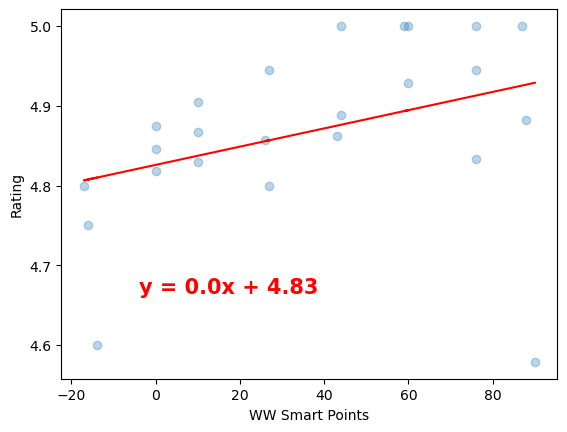

In [326]:
x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

## RESEARCH HOW TO PLOT MULTI-INDEX DATAFRAME

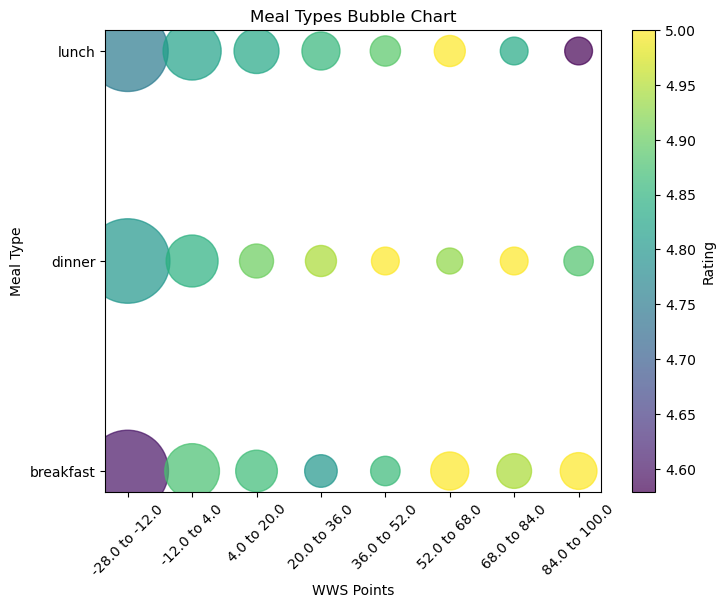

In [332]:
# Extract data for plotting
x = binned_df.index.get_level_values('WWS Point Ranges')
y = binned_df.index.get_level_values('meal_type')
size = binned_df['protein_g']*10  # Size of the bubbles
colour = binned_df['rating']  # Color of the bubbles

# Create the bubble chart
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x, y, s=size * 10, c=colour, cmap='viridis', alpha=0.7)

# Add labels and a colorbar
ax.set_xlabel('WWS Points')
plt.xticks(rotation=45)
ax.set_ylabel('Meal Type')
ax.set_title('Meal Types Bubble Chart')
cbar = plt.colorbar(scatter)
cbar.set_label('Rating')

plt.show()

In [186]:
# THOUGHTS: Group by ratings instead? Rather than points? More robust and less iffy that way?
# ANSWER: Tried it, doesn't really work!

In [187]:
updated_types = clean_recipes['meal_type'].unique()
updated_types = ['breakfast', 'lunch', 'dinner']

# Breakfast
breakfast = clean_recipes.loc[clean_recipes['meal_type'] == "breakfast"].copy()
print(f'breakfast: {breakfast.shape}')

# Lunch
lunch = clean_recipes.loc[clean_recipes['meal_type'] == "lunch"].copy()
print(f'lunch: {lunch.shape}')

# Dinner
dinner = clean_recipes.loc[clean_recipes['meal_type'] == "dinner"].copy()
print(f'dinner: {dinner.shape}')

breakfast: (1628, 29)
lunch: (3213, 29)
dinner: (6359, 29)


breakfast R-value: 0.16
lunch R-value: 0.0
dinner R-value: 0.49


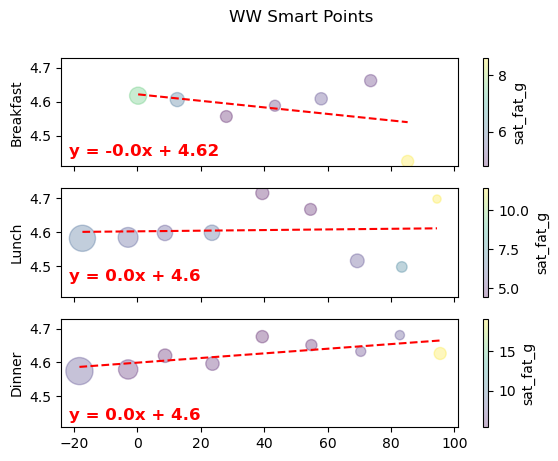

In [321]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle("WW Smart Points")
x_col = 'wws_points'
y_col = 'rating'
size_col = 'protein_g'
colour_col = 'sat_fat_g'

df_list = [breakfast, lunch, dinner]

for idx, val in enumerate(df_list):

    # Bin by `wws_points`
    min_points = df_list[idx]['wws_points'].describe().min()
    max_points = df_list[idx]['wws_points'].describe().max()
    
    # Create bins
    points_bins = np.arange(min_points+16, max_points, 15) # 5 was good with less granular cuisines
    points_labels = [f'{points_bins[i]} to {points_bins[i+1]}' for i in range(len(points_bins)-1)]
    bins_df = pd.cut(df_list[idx]['wws_points'], bins=points_bins, labels=points_labels)
    
    # Set the index and its name
    points_df = df_list[idx].set_index(bins_df)
    points_df.index.name = "WWS Point Ranges"
    
    # Create grouped DataFrame by numeric means
    binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
    binned_df

    # Extract x- and y-values
    x = binned_df[x_col]
    y = binned_df[y_col]
    size = binned_df[size_col]
    colour = binned_df[colour_col]

    scatter_plot = axs[idx].scatter(x, y, s=size*10, alpha=0.3, c=colour)
    axs[idx].set_ylabel(updated_types[idx].title())
    cbar = plt.colorbar(scatter_plot)
    cbar.set_label(colour_col)

    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x, y)
    line_equation = f'y = {round(slope, 2)}x + {round(intercept, 2)}'
    regression_values = slope * x + intercept
    axs[idx].plot(x, regression_values, linestyle='--', c='red')
    if idx == 0:
        x_coord, y_coord = 50, 220
    elif idx == 1:
        x_coord, y_coord = 50, 130
    elif idx == 2:
        x_coord, y_coord = 50, 30
    axs[idx].annotate(line_equation, xy=(x_coord, y_coord), xycoords='figure points',
        fontsize = 12, color='red', weight='bold')

    print(f'{updated_types[idx]} R-value: {round(rvalue**2, 2)}')

fig.savefig('Meal types and WW Smart Points1.png')

In [189]:
# Bin and count to get percentages?
meal_median = []
for idx, val in enumerate(df_list):
    meal_median.append(df_list[idx]['wws_points'].describe()['50%'])
mealmedian_avg = np.mean(meal_median)
mealmedian_avg # Cut off for healthiness

# THIS WOULD JUST MAKE IT 50% healthy and 50% unhealthy???
# Use nutritional values instead, and create percentage comparisons based on how many exceed all values? Is this realistic?

7.666666666666667

### Cuisines

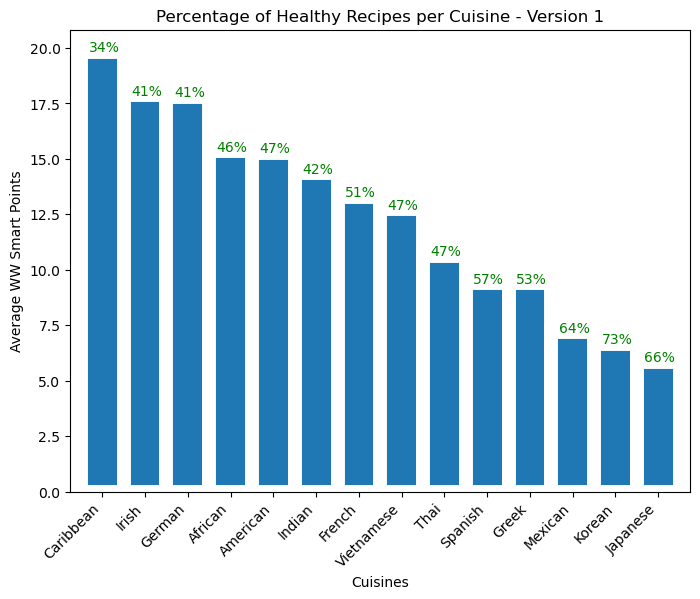

In [439]:
cuisine_df = clean_recipes.groupby(['cuisine']).mean(numeric_only=True)
# bar_chart = cuisine_df['wws_points'].sort_values(ascending=False).plot(kind="bar", color="green")
# col_order = cuisine_df['wws_points'].sort_values(ascending=False).index
# col_order

# Get percentage of "healthy" recipes per cuisine
# Set the limit as the median 'wws_points'
wws_median = clean_recipes['wws_points'].describe()['50%']

# Get the total number of recipes per cuisine
cuisine_count = clean_recipes.groupby(['cuisine'])['id'].count()

# Create a DataFrame of recipes that sit above the median 'wws_points'
healthy_count = clean_recipes.loc[clean_recipes['wws_points'] < wws_median]

# Create a groupby DataFrame that counts the number of healthy recipes
healthy_group = healthy_count.groupby(['cuisine'])['id'].count()

# Calculate the percentage value
percent_healthy = []
for idx in range(len(cuisine_count)):
    percent_healthy.append(int(healthy_group[idx] * 100 / cuisine_count[idx]))

# Create a DataFrame with calculated percentages, add the average WWS Points as a new column
percent_df = pd.DataFrame(percent_healthy, index=healthy_group.index, columns=['percent_healthy'])
percent_df['ave_wws_points'] = cuisine_df['wws_points']

# Sort the values and reset index to recover 'cuisine'
percent_df = percent_df.sort_values(by=['ave_wws_points'], ascending=False).reset_index()

# Annotate the bar chart with the second dataset
bar_chart = percent_df['ave_wws_points'].plot(
    kind = "bar",
    title = "Percentage of Healthy Recipes per Cuisine - Version 1",
    figsize = (8,6),
    width = 1,
    linewidth = 10,
    edgecolor = "white")
bar_chart.set_xlabel("Cuisines")
bar_chart.set_ylabel("Average WW Smart Points")
cuisine_titles = [word.title() for word in percent_df['cuisine']]
bar_chart.set_xticklabels(
    cuisine_titles,
    rotation_mode='default',
    rotation=45,
    ha='right')

for index, row in percent_df.iterrows():
    plt.annotate(
        f"{row['percent_healthy']}%", color="green",
        xy=(row.name, cuisine_df[cuisine_df.index == row['cuisine']]['wws_points']),
        xytext=(-10,0), textcoords='offset points')

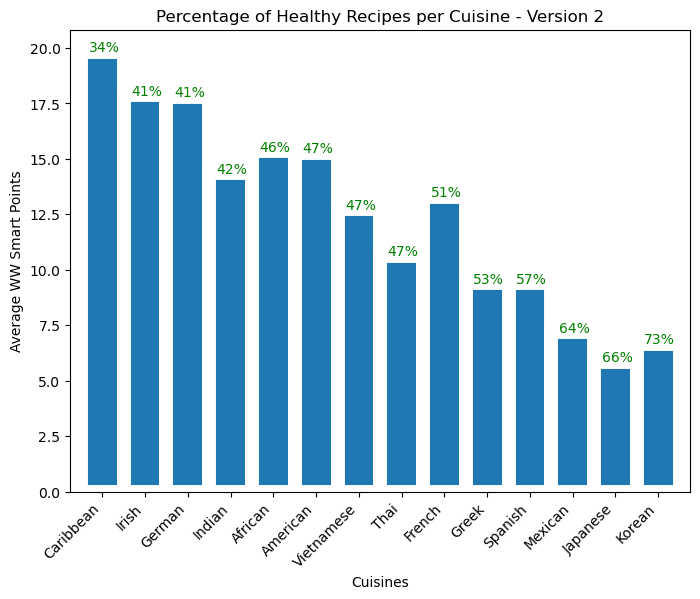

In [440]:
# Sort the values and reset index to recover 'cuisine'
percent_df = percent_df.sort_values(by=['percent_healthy'], ascending=True).reset_index()

# Annotate the bar chart with the second dataset
bar_chart = percent_df['ave_wws_points'].plot(
    kind = "bar",
    title = "Percentage of Healthy Recipes per Cuisine - Version 2",
    figsize = (8,6),
    width = 1,
    linewidth = 10,
    edgecolor = "white")
bar_chart.set_xlabel("Cuisines")
bar_chart.set_ylabel("Average WW Smart Points")
cuisine_titles = [word.title() for word in percent_df['cuisine']]
bar_chart.set_xticklabels(
    cuisine_titles,
    rotation_mode='default',
    rotation=45,
    ha='right')

for index, row in percent_df.iterrows():
    plt.annotate(
        f"{row['percent_healthy']}%", color="green",
        xy=(row.name, cuisine_df[cuisine_df.index == row['cuisine']]['wws_points']),
        xytext=(-10,0), textcoords='offset points')

<Axes: >

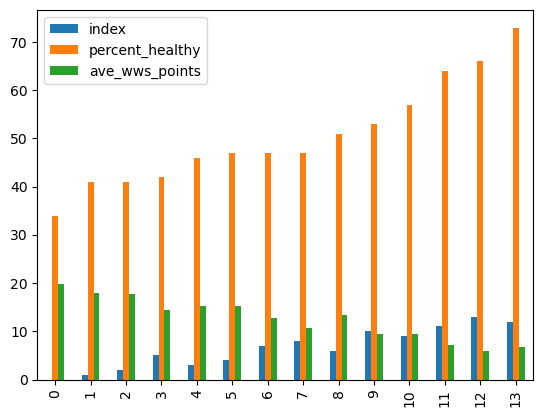

In [441]:
# Version 3 - This just looks messy, since combining two different y-axes!
percent_df.plot(kind="bar")

### Popularity

In [57]:
# Bin by `wws_points` then groupby each meal type
min_points = clean_recipes['wws_points'].describe().min()
max_points = clean_recipes['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins)

# Set the index and its name
points_df = clean_recipes.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).median(numeric_only=True) # originally mean
binned_df

,id,minutes,contributor_id,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
WWS Point Ranges,,,,,,,,,,,,,,,,,,,,
"(-44.0, -28.0]",206826.5,35.0,192195.0,9.0,9.0,4.801282,417.45,29.0,2.0,19.0,102.5,26.0,1.0,18.85,1.0,0.456,51.25,5.2,3.0,-31.0
"(-28.0, -12.0]",170382.0,35.0,130159.0,10.0,9.0,4.789474,372.20,26.0,6.0,20.0,71.0,27.0,2.0,16.90,3.0,0.480,35.50,5.4,6.0,-17.0
"(-12.0, 4.0]",184880.0,30.0,153190.0,9.0,9.0,4.857143,264.20,19.0,6.0,17.0,32.0,21.0,4.0,12.35,3.0,0.408,16.00,4.2,12.0,0.0
"(4.0, 20.0]",190812.0,30.0,148316.0,9.0,9.0,4.888889,265.20,20.0,16.0,15.0,17.0,20.0,7.0,13.00,8.0,0.360,8.50,4.0,21.0,10.0
"(20.0, 36.0]",185246.5,30.5,143318.0,8.0,9.0,4.890681,252.05,17.0,41.0,11.0,12.0,18.0,8.0,11.05,20.5,0.264,6.00,3.6,24.0,27.0
"(36.0, 52.0]",176808.5,34.0,118530.5,9.0,9.0,5.000000,269.55,17.0,68.0,7.0,9.0,20.0,10.0,11.05,34.0,0.168,4.50,4.0,30.0,44.0
"(52.0, 68.0]",174168.5,35.0,122790.5,9.0,8.0,5.000000,298.45,18.0,92.0,7.0,10.0,21.5,12.0,11.70,46.0,0.168,5.00,4.3,36.0,60.0
"(68.0, 84.0]",167064.0,40.0,83400.0,10.0,8.0,5.000000,332.40,23.0,113.0,7.0,9.0,34.0,14.0,14.95,56.5,0.168,4.50,6.8,42.0,75.0
"(84.0, 100.0]",242955.0,45.0,266635.0,15.0,10.0,5.000000,514.70,42.0,123.0,11.0,10.0,65.0,16.0,27.30,61.5,0.264,5.00,13.0,48.0,87.0


The r-value is: 0.8992348560527099


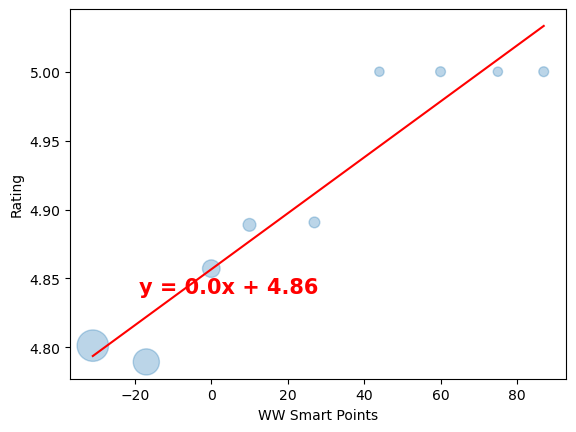

In [58]:
x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

### 5-Star Ratings

In [59]:
# Get the DataFrame for 5-star ratings
top_rated = clean_recipes.loc[clean_recipes['rating'] >= 5].copy()
print(f'top_rated: {top_rated.shape}')

top_rated: (6087, 29)


In [60]:
# Get the DataFrame for all other ratings
bottom_rated = clean_recipes.loc[clean_recipes['rating'] < 5].copy()
print(f'bottom_rated: {bottom_rated.shape}')

bottom_rated: (6629, 29)


The r-value is: 0.729764295148561


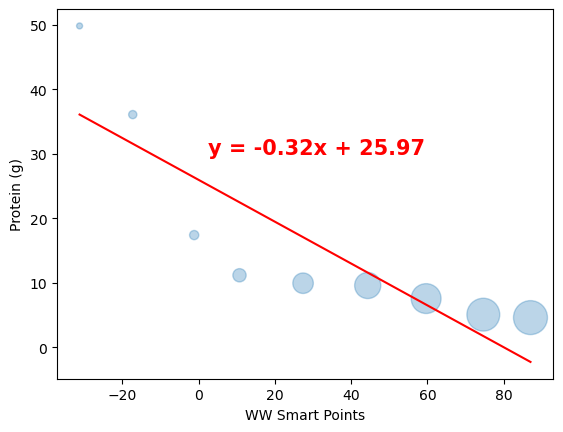

In [61]:
# Bin by `wws_points` then groupby each meal type
min_points = bottom_rated['wws_points'].describe().min()
max_points = bottom_rated['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(bottom_rated['wws_points'], bins=points_bins)

# Set the index and its name
points_df = bottom_rated.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
binned_df

x_val = binned_df['wws_points']
y_val = binned_df['protein_g']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['sugar_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Protein (g)")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 150, 200)

The r-value is: 0.7090846056978947


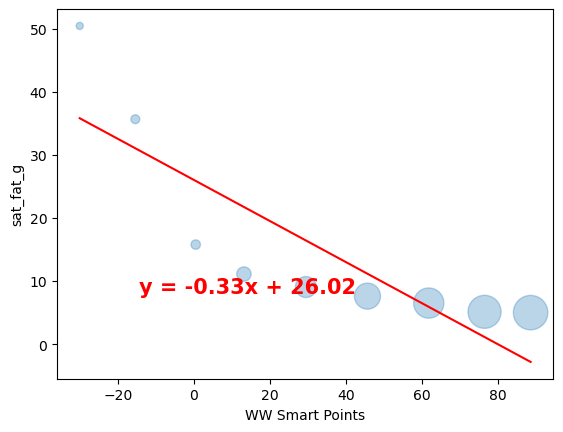

In [62]:
# Bin by `wws_points` then groupby each meal type
min_points = top_rated['wws_points'].describe().min()
max_points = top_rated['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(top_rated['wws_points'], bins=points_bins)

# Set the index and its name
points_df = top_rated.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
binned_df


x_val = binned_df['wws_points']
y_val = binned_df['protein_g']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['sugar_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("sat_fat_g")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

### Lowest WW Smart Points

In [63]:
low_points = clean_recipes.loc[clean_recipes['wws_points'] < -40].copy()
low_points.describe()
low_points.shape

(3, 29)

The r-value is: 0.892857142857143


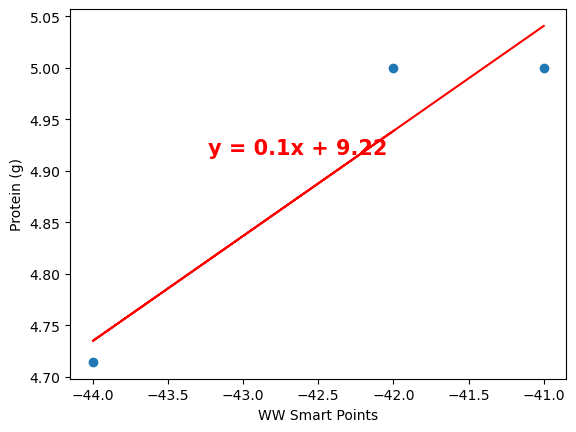

In [64]:
# Bin by `wws_points` then groupby each meal type
min_points = low_points['wws_points'].describe().min()
max_points = low_points['wws_points'].describe().max()

x_val = low_points['wws_points']
y_val = low_points['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Protein (g)")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 150, 200)

In [65]:
low_points['id']

9042      290232
78163     133946
183106    118063
Name: id, dtype: int64

In [66]:
low_points

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
9042,asian flavoured chicken burgers oamc,290232,15,506519,2008-03-05,"['lactose', '15-minutes-or-less', 'time-to-mak...","[375.6, 14.0, 5.0, 12.0, 114.0, 12.0, 3.0]",4,['place all ingredients in a bowl and mix unti...,light and freshly flavoured burgers. these are...,...,114.0,12.0,3.0,9.10,2.5,0.288,57.0,2.4,9.0,-41
78163,egyptian red snapper in red pepper mint sauce,133946,20,183964,2005-08-18,"['30-minutes-or-less', 'time-to-make', 'course...","[328.6, 9.0, 7.0, 5.0, 120.0, 5.0, 1.0]",4,"['saute onion in olive oil until golden', 'add...",this recipe is posted for the zaar world tour ...,...,120.0,5.0,1.0,5.85,3.5,0.120,60.0,1.0,3.0,-44
183106,simple salsa chicken,118063,40,28604,2005-04-19,"['60-minutes-or-less', 'time-to-make', 'course...","[335.0, 11.0, 8.0, 26.0, 118.0, 18.0, 1.0]",9,['spray a shallow baking dish with cooking spr...,"ok, so this can serve 10 people, if each perso...",...,118.0,18.0,1.0,7.15,4.0,0.624,59.0,3.6,3.0,-42


The r-value is: 0.7245991621112193


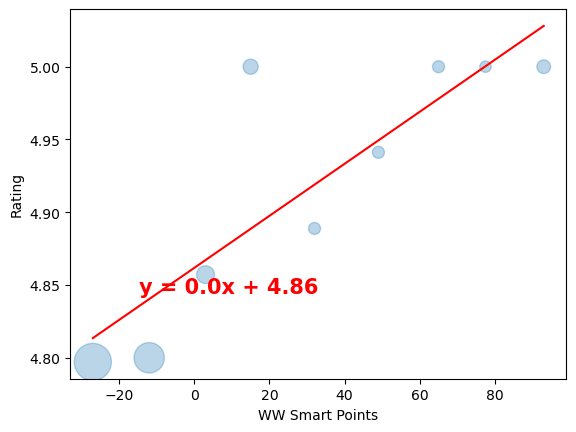

In [67]:
# Remove outliers?
clean_recipes1 = clean_recipes.loc[~clean_recipes['id'].isin(low_points['id'])]

# Bin by `wws_points` then groupby each meal type
min_points = clean_recipes1['wws_points'].describe().min()
max_points = clean_recipes1['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(clean_recipes1['wws_points'], bins=points_bins)

# Set the index and its name
points_df = clean_recipes1.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).median(numeric_only=True) # originally mean
binned_df

x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*15, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

# Data Exploration - Spoonacular API

## API Testing

### Complex Search and Recipe Information
- Complex Search: [https://spoonacular.com/food-api/docs#Search-Recipes-Complex](https://spoonacular.com/food-api/docs#Search-Recipes-Complex)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- `Complex Search` returns the same result every time, need to try `Random Recipes`.

In [68]:
# Uncomment below to run [API REQUEST - Complex Search]
# complex_search()

# Import and display complex search results
recipes_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_0.csv')
print(f'recipes_df: {recipes_df.shape}')
recipes_df.head()

# Uncomment below to run [API REQUEST - Recipe Information]
# recipe_info('Resources/02_raw_data/info_master_0.csv')

# Uncomment below to run [API ACTIVE - Check Response]
# check_response()

recipes_df: (100, 4)


,id,title,image,imageType
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,https://spoonacular.com/recipeImages/782585-31...,jpg
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",https://spoonacular.com/recipeImages/716426-31...,jpg
2,715497,Berry Banana Breakfast Smoothie,https://spoonacular.com/recipeImages/715497-31...,jpg
3,715415,Red Lentil Soup with Chicken and Turnips,https://spoonacular.com/recipeImages/715415-31...,jpg
4,716406,Asparagus and Pea Soup: Real Convenience Food,https://spoonacular.com/recipeImages/716406-31...,jpg


In [69]:
# Import and display recipe information results
info_df = pd.read_csv(f'Resources/02_raw_data/info_master_0.csv')

# Display the DataFrame and its columns
print(info_df.columns)
info_df.head()

Index(['Unnamed: 0', 'vegetarian', 'vegan', 'glutenFree', 'dairyFree',
       'veryHealthy', 'cheap', 'veryPopular', 'sustainable', 'lowFodmap',
       'weightWatcherSmartPoints', 'gaps', 'preparationMinutes',
       'cookingMinutes', 'aggregateLikes', 'healthScore', 'creditsText',
       'sourceName', 'pricePerServing', 'extendedIngredients', 'id', 'title',
       'readyInMinutes', 'servings', 'sourceUrl', 'image', 'imageType',
       'nutrition', 'summary', 'cuisines', 'dishTypes', 'diets', 'occasions',
       'winePairing', 'instructions', 'analyzedInstructions', 'originalId',
       'spoonacularSourceUrl', 'license', 'author'],
      dtype='object')


,Unnamed: 0,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,...,dishTypes,diets,occasions,winePairing,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,license,author
0,0,True,True,True,True,True,False,False,False,False,...,"['side dish', 'lunch', 'main course', 'salad',...","['gluten free', 'dairy free', 'lacto ovo veget...",[],"{'pairedWines': ['chardonnay', 'sauvignon blan...",Rinse the cannellini beans and soak for 8 hour...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/cannellini-bean-and-as...,NaN,NaN
1,1,True,True,True,True,True,False,True,False,False,...,"['side dish', 'antipasti', 'starter', 'snack',...","['gluten free', 'dairy free', 'lacto ovo veget...",[],"{'pairedWines': ['wine', 'alcoholic drink', 'w...",<ol><li><span></span>Remove the cauliflower's ...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/cauliflower-brown-rice...,CC BY-SA 3.0,NaN
2,2,True,False,False,False,True,False,True,False,False,...,"['morning meal', 'brunch', 'beverage', 'breakf...",['lacto ovo vegetarian'],[],"{'pairedWines': [], 'pairingText': '', 'produc...",<p>Take some yogurt in your favorite flavor an...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/berry-banana-breakfast...,NaN,NaN
3,3,False,False,True,True,True,False,True,False,False,...,"['lunch', 'soup', 'main course', 'main dish', ...","['gluten free', 'dairy free']","['fall', 'winter']","{'pairedWines': [], 'pairingText': '', 'produc...","To a large dutch oven or soup pot, heat the ol...","[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/red-lentil-soup-with-c...,NaN,NaN
4,4,True,True,True,True,True,False,False,False,False,...,"['antipasti', 'soup', 'starter', 'snack', 'app...","['gluten free', 'dairy free', 'paleolithic', '...","['fall', 'winter']","{'pairedWines': ['sparkling wine', 'sparkling ...",<ol><li><span></span>Chop the garlic and onion...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/asparagus-and-pea-soup...,CC BY-SA 3.0,NaN


In [70]:
# Parse the API response - all relevant columns, and account for different units

# Uncomment below to run [API ACTIVE - Parse Response]
# parse_response('Resources/03_simplified_data/initial_nutrition_0.csv')

# Import and display recipe information results
simple_df = pd.read_csv(f'Resources/03_simplified_data/initial_nutrition_0.csv')

# Display the DataFrame and its columns
print(simple_df.columns)
simple_df.head()

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)'],
      dtype='object')


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,309,"['side dish', 'lunch', 'main course', 'salad',...",[],13,12,488.93,kcal,24.45,...,6.49,4.29,g,4.76,421.70,mg,18.33,32.02,g,64.03
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",3689,"['side dish', 'antipasti', 'starter', 'snack',...","['Chinese', 'Asian']",15,4,220.82,kcal,11.04,...,6.99,5.29,g,5.87,445.90,mg,19.39,9.03,g,18.05
2,715497,Berry Banana Breakfast Smoothie,689,"['morning meal', 'brunch', 'beverage', 'breakf...",[],5,15,457.05,kcal,22.85,...,16.88,52.28,g,58.09,400.90,mg,17.43,20.62,g,41.25
3,715415,Red Lentil Soup with Chicken and Turnips,1866,"['lunch', 'soup', 'main course', 'main dish', ...",[],13,11,477.24,kcal,23.86,...,19.37,10.55,g,11.72,1335.78,mg,58.08,26.93,g,53.86
4,716406,Asparagus and Pea Soup: Real Convenience Food,207,"['antipasti', 'soup', 'starter', 'snack', 'app...",[],8,2,452.33,kcal,22.62,...,8.34,27.99,g,31.10,25.76,mg,1.12,26.56,g,53.12


In [71]:
# Check the units columns
units_columns = ['Calories (Unit)', 'Saturated Fat (Unit)', 'Sugar (Unit)', 'Sodium (Unit)', 'Protein (Unit)']
for col in units_columns:
    check = simple_df[col].unique()
    print(f"Unit check: {col} {check}")

# Account for the differences when calculating points

Unit check: Calories (Unit) ['kcal']
Unit check: Saturated Fat (Unit) ['g']
Unit check: Sugar (Unit) ['g']
Unit check: Sodium (Unit) ['mg']
Unit check: Protein (Unit) ['g' 'mg']


### Random Recipes and Recipe Information
- Random Recipes: [https://spoonacular.com/food-api/docs#Get-Random-Recipes](https://spoonacular.com/food-api/docs#Get-Random-Recipes)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- Once converted to a dataframe, the data is not as accessible as navigating the API response, will need to create a simplified dataframe while the API response is available.
- Although this has metadata, it still does not have `Nutrition` information, will still need to run the `Recipe Information` request. Need to identify a cost-effective API request methodology.

In [72]:
# Uncomment below to run [API REQUEST - Random Recipe]
# random_recipe('Resources/01_recipe_IDs/initial_recipes_4.csv')

# Import and display random recipes results
random_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_4.csv')
random_df.head()

,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,weightWatcherSmartPoints,...,cuisines,dishTypes,diets,occasions,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,license,author
0,False,False,False,False,False,False,False,False,False,28,...,['American'],"['lunch', 'main course', 'main dish', 'dinner']",[],[],<ol><li>Preheat broiler. </li><li>Heat large f...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tex-mex-burger-663050,NaN,NaN
1,False,False,False,False,False,False,False,False,False,39,...,[],['dessert'],[],[],<ol><li>Preheat oven to 180 degrees C</li><li>...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/chocolate-banoffee-pie...,CC BY 3.0,NaN
2,True,True,True,True,False,False,False,False,False,3,...,[],"['side dish', 'antipasti', 'salad', 'starter',...","['gluten free', 'dairy free', 'paleolithic', '...",['christmas'],Finely grate enough zest from the orange to me...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/fennel-and-orange-sala...,CC BY 3.0,NaN
3,False,False,False,True,False,False,False,False,False,12,...,['Mexican'],"['lunch', 'main course', 'main dish', 'dinner']","['dairy free', 'pescatarian']",[],In pie pan/deep dish add your Italian bread cr...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/kks-fish-tacos-648974,NaN,NaN
4,True,True,True,True,True,False,False,False,False,6,...,[],"['lunch', 'soup', 'main course', 'main dish', ...","['gluten free', 'dairy free', 'lacto ovo veget...","['fall', 'winter']",<ol><li>Rinse the beans thoroughly and place t...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tuscan-white-bean-soup...,NaN,NaN


In [73]:
# # Uncomment block to run [API REQUEST - Recipe Information]
# recipe_info('Resources/02_raw_data/info_master_4.csv')

# # Uncomment block to run [API ACTIVE - Parse Response]
# parse_response('Resources/03_simplified_data/initial_nutrition_4.csv')

### Random Recipes and Nutrition by ID

In [74]:
# # Uncomment block to run [API REQUEST - Random Recipe and Nutrition by ID]
# recipe_info('Resources/02_raw_data/info_master_5.csv')

# # Uncomment block to run [API REQUEST - Nutrition by ID]
# nutrition_id('Resources/02_raw_data/info_master_5.csv')

# # Uncomment block to parse the response (added carbohydrates)
# parse_metadata(
#     'Resources/01_recipe_IDs/initial_recipes_5.csv',
#     'Resources/03_simplified_data/initial_nutrition_5.csv')

## Spoonacular API Data Collection
__Method 1__

- API request cost comparison:
    * Type 1: `Random Recipes` + `Recipe Information` = 2.1 points per request
    * Type 2: `Random Recipes` + `Nutrition by ID` = 2 points per request

__Method 2__

* `Complex Search` with a more comprehensive params dictionary.
* Identified as the most cost-efficient method, a single request with all the details.

__Method 3__
* `Recipe Information` requests only.
* Used for getting information when Recipe IDs already exist.

In [75]:
# Uncomment the line below to run Method 1
# spoonacular_v1(type=2)

# Uncomment the line below to run the API request
# spoonacular_v2()

## Get Recipe IDs from Raw Data

In [76]:
# Get list of subdirectories in the Resources folder
from pathlib import Path
subdir_list = []
for path in Path('Resources').iterdir():
    # Ignore `.ipynb_checkpoints`
    if (path == Path('Resources/.ipynb_checkpoints')):
        continue
    elif path.is_dir():
        subdir_list.append(path)

# Loop over folders without simplified data
raw_ids = []
raw_files = []
for dir in subdir_list[0:2]:
    # Read each file in the directory
    for file in os.scandir(dir):
        # Check if the file is NOT a directory, ignore `.ipynb_checkpoints`
        if os.path.isfile(file) & (file.name != '.ipynb_checkpoints'):
            filename = f'{dir}/{file.name}'
            csv_df = pd.read_csv(filename)
            try:
                raw_ids.append(csv_df['id'])
                raw_files.append(filename)
            except:
                # If no 'id' column, move on to the next csv
                continue

# Get a unique list of recipe IDs
raw_list = [id for row in raw_ids for id in row]
unique_raw = list(set(raw_list))

# Remove NaN values from unique_raw
clean_raw = []
for value in unique_raw:
    try:
        clean_raw.append(int(value))
    except:
        # Value cannot be cast to int
        continue
print(f'Unique out of raw data: {len(clean_raw)} of {len(raw_list)}')

# Loop over folders with simplified data
simple_ids = []
simple_files = []
for dir in subdir_list[2:]:
    # Read each file in the directory
    for file in os.scandir(dir):
        # Check if the file is NOT a directory, ignore `.ipynb_checkpoints`
        if os.path.isfile(file) & (file.name != '.ipynb_checkpoints') & (file.name.split('.')[-1] == 'csv'):
                filename = f'{dir}/{file.name}'
                csv_df = pd.read_csv(filename)
                try:
                    try:
                        simple_ids.append(csv_df['id'])
                    except:
                        simple_ids.append(csv_df['ID'])
                    simple_files.append(filename)
                except:
                    # If no 'id' column, move on to the next csv
                    continue

# Get a unique list of recipe IDs
simple_list = [id for row in simple_ids for id in row]
unique_simple = list(set(simple_list))
print(f'Unique out of simplified data: {len(unique_simple)} of {len(simple_list)}')

# Identify the intersection between the unique raw and unique simplified data
intersect_ids = []
missing_ids = set(clean_raw).difference(set(unique_simple))
if set(clean_raw) & set(unique_simple):
    intersect_ids.append(set(clean_raw) & set(unique_simple))
print(f'Total intersection: {len(intersect_ids[0])}')
print(f'Total missing: {len(missing_ids)}')

Unique out of raw data: 1074 of 2339
Unique out of simplified data: 1074 of 1637
Total intersection: 1074
Total missing: 0


In [77]:
# If there are IDs with missing information, get the data
if len(missing_ids) > 0:
    spoonacular_v3(missing_ids)

### Get Missing Data from another column (Simplified Data)

In [78]:
# Import one file from 03_simplified_data as a reference
simple_ref = pd.read_csv('Resources/03_simplified_data/initial_nutrition_7.csv').columns
simple_ref

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates'],
      dtype='object')

In [79]:
# Import one file from 04_complex_test as a reference
complex_ref = pd.read_csv('Resources/04_complex_test/simplified_data_0.csv').columns
complex_ref

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Cooking Minutes', 'Prep Minutes',
       'Calories (Amount)', 'Calories (Unit)', 'Calories (% of Daily Needs)',
       'Saturated Fat (Amount)', 'Saturated Fat (Unit)',
       'Saturated Fat (% of Daily Needs)', 'Sugar (Amount)', 'Sugar (Unit)',
       'Sugar (% of Daily Needs)', 'Sodium (Amount)', 'Sodium (Unit)',
       'Sodium (% of Daily Needs)', 'Protein (Amount)', 'Protein (Unit)',
       'Protein (% of Daily Needs)', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)'],
      dtype='object')

In [80]:
# Read each simplified data file and create a DataFrame
df_list = []
for file in simple_files:
    one_df = pd.read_csv(file)
    df_list.append(one_df)
simplified_df = pd.concat(df_list, ignore_index=True)

# Identify duplicate IDs
duplicate_IDs = simplified_df.loc[simplified_df.duplicated(['ID'])]
print(f'Number of duplicate rows to remove: {duplicate_IDs.shape[0]}')

# Create a new DataFrame without the duplicates
simplified_df = simplified_df.loc[~simplified_df.duplicated(['ID'])].copy()

# Display the DataFrame, columns, and shape
print(f'simplified_df: {simplified_df.shape}')
print(simplified_df.columns)
simplified_df.head()

Number of duplicate rows to remove: 563
simplified_df: (1074, 28)
Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates', 'Cooking Minutes', 'Prep Minutes', 'Carbs (Amount)',
       'Carbs (Unit)', 'Carbs (% of Daily Needs)'],
      dtype='object')


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs),Carbohydrates,Cooking Minutes,Prep Minutes,Carbs (Amount),Carbs (Unit),Carbs (% of Daily Needs)
0,664101,Turkish squares,3,['side dish'],[],11,25.0,603.77,kcal,30.19,...,14.43,12.59,g,25.17,87g,NaN,NaN,NaN,NaN,NaN
1,636732,Cajun Lobster Pasta,2,"['side dish', 'lunch', 'main course', 'main di...","['Creole', 'Cajun']",17,22.0,734.22,kcal,36.71,...,99.96,36.92,g,73.84,39g,NaN,NaN,NaN,NaN,NaN
2,633078,Authentic Italian Biscotti,24,['dessert'],"['Mediterranean', 'Italian', 'European']",8,2.0,54.31,kcal,2.72,...,2.70,1.37,g,2.75,8g,NaN,NaN,NaN,NaN,NaN
3,632075,All Day Simple Slow-Cooker FALL OFF the BONE Ribs,61,"['antipasti', 'starter', 'snack', 'appetizer',...",[],4,29.0,614.38,kcal,30.72,...,128.53,9.57,g,19.14,117g,NaN,NaN,NaN,NaN,NaN
4,715562,Loaded Baked Potato Soup,5743,"['lunch', 'soup', 'main course', 'main dish', ...",[],9,24.0,623.73,kcal,31.19,...,26.09,21.16,g,42.32,58g,NaN,NaN,NaN,NaN,NaN


In [81]:
# Read each raw data file and create a DataFrame
df_list = []
for file in raw_files:
    one_df = pd.read_csv(file)
    df_list.append(one_df)
raw_df = pd.concat(df_list, ignore_index=True)

# Drop rows with missing IDs
raw_df = raw_df.loc[~raw_df['id'].isna()]

# Reduce DataFrame to unique IDs
raw_df = raw_df.loc[~raw_df.duplicated(['id'])].copy()

# Display the DataFrame, columns, and shape
print(f'raw_df: {raw_df.shape}')
print(raw_df.columns)
raw_df.head()

raw_df: (1074, 43)
Index(['vegetarian', 'vegan', 'glutenFree', 'dairyFree', 'veryHealthy',
       'cheap', 'veryPopular', 'sustainable', 'lowFodmap',
       'weightWatcherSmartPoints', 'gaps', 'preparationMinutes',
       'cookingMinutes', 'aggregateLikes', 'healthScore', 'creditsText',
       'sourceName', 'pricePerServing', 'extendedIngredients', 'id', 'title',
       'readyInMinutes', 'servings', 'sourceUrl', 'image', 'imageType',
       'nutrition', 'summary', 'cuisines', 'dishTypes', 'diets', 'occasions',
       'winePairing', 'instructions', 'analyzedInstructions', 'originalId',
       'spoonacularSourceUrl', 'author', 'license', 'status', 'code',
       'message', 'Unnamed: 0'],
      dtype='object')


,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,weightWatcherSmartPoints,...,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,author,license,status,code,message,Unnamed: 0
0,False,False,False,False,False,False,False,False,False,31.0,...,"<ol><li>While potatoes are frying, heat vegeta...","[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/best-breakfast-burrito...,NaN,NaN,NaN,NaN,NaN,NaN
1,False,False,True,False,False,False,False,False,False,19.0,...,"<p>1. Pre-heat oven to ~450°F (230°C), top hea...","[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/pittata-pizza-frittata...,coffeebean,NaN,NaN,NaN,NaN,NaN
2,True,True,True,True,True,False,False,False,False,8.0,...,Saut onion and garlic in olive oil for 5 minut...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tomato-and-lentil-soup...,NaN,NaN,NaN,NaN,NaN,NaN
3,True,False,False,False,False,False,False,False,False,8.0,...,<ol><li>Preheat oven to 375F with the rack in ...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/savory-cheese-dill-sco...,NaN,CC BY 3.0,NaN,NaN,NaN,NaN
4,False,False,True,True,False,False,False,False,False,5.0,...,<ol><li><span></span>Heat a skillet over mediu...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/garlic-lemon-pepper-sh...,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# Minimum columns required
min_cols = ['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Cooking Minutes', 'Calories (Amount)', 'Calories (Unit)',
        'Calories (% of Daily Needs)', 'Saturated Fat (Amount)', 'Saturated Fat (Unit)',
       'Saturated Fat (% of Daily Needs)', 'Sugar (Amount)', 'Sugar (Unit)',
       'Sugar (% of Daily Needs)', 'Sodium (Amount)', 'Sodium (Unit)',
       'Sodium (% of Daily Needs)', 'Protein (Amount)', 'Protein (Unit)',
       'Protein (% of Daily Needs)', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)']

# Identify columns with missing data
missing_cols = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 601
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 601
Carbs (Unit): 601
Carbs (% of Daily Needs): 601

Columns with null values: ['Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)', 'Carbs (% of Daily Needs)']


### Get Missing Data from elsewhere (Raw Data)

In [83]:
# Get the list of recipe IDs with missing data
missing_recipes = check_na['ID']

# Check if the missing data have rows in raw_df
find_missing = raw_df.loc[raw_df['id'].isin(missing_recipes)]

# Check if there is a nutrition column for the missing data
find_nutrition = raw_df.loc[~raw_df['nutrition'].isna()]
print(f'Missing recipes in raw_df with a nutrition column: {len(find_nutrition)}')

Missing recipes in raw_df with a nutrition column: 886


In [84]:
# Test get_nutrition() function
test_nutrition = get_nutrition(raw_df['nutrition'][0], 'Carbohydrates')
test_nutrition

[98.02, 'g', 32.67]

In [85]:
# Populate simplified_df with the missing data
for df_idx, row in find_nutrition.iterrows():
    result = get_nutrition(row['nutrition'], 'Carbohydrates')
    recipe_id = find_nutrition.loc[df_idx, 'id']
    simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Amount)'] = result[0]
    simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Unit)'] = result[1]
    simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (% of Daily Needs)'] = result[2]

# Identify columns with missing data
missing_cols = []
missing_ids = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
        missing_ids.append(check_na['ID'])
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

# Flatten list of missing IDs
missing_list = [id for id_list in missing_ids for id in id_list]

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 601
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 188
Carbs (Unit): 188
Carbs (% of Daily Needs): 188

Columns with null values: ['Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)', 'Carbs (% of Daily Needs)']


In [86]:
# Identify the recipes with still missing values
still_missing = simplified_df.loc[simplified_df['ID'].isin(missing_list)]
check_column = still_missing.loc[still_missing['Carbohydrates'].isna()]

# Display the DataFrame
print(f'Carbohydrates column with missing values: {len(check_column)}')
still_missing.head() # Data is in 'Carbohydrates' column

Carbohydrates column with missing values: 256


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs),Carbohydrates,Cooking Minutes,Prep Minutes,Carbs (Amount),Carbs (Unit),Carbs (% of Daily Needs)
0,664101,Turkish squares,3,['side dish'],[],11,25.0,603.77,kcal,30.19,...,14.43,12.59,g,25.17,87g,NaN,NaN,87.04,g,29.01
1,636732,Cajun Lobster Pasta,2,"['side dish', 'lunch', 'main course', 'main di...","['Creole', 'Cajun']",17,22.0,734.22,kcal,36.71,...,99.96,36.92,g,73.84,39g,NaN,NaN,NaN,NaN,NaN
2,633078,Authentic Italian Biscotti,24,['dessert'],"['Mediterranean', 'Italian', 'European']",8,2.0,54.31,kcal,2.72,...,2.70,1.37,g,2.75,8g,NaN,NaN,8.17,g,2.72
3,632075,All Day Simple Slow-Cooker FALL OFF the BONE Ribs,61,"['antipasti', 'starter', 'snack', 'appetizer',...",[],4,29.0,614.38,kcal,30.72,...,128.53,9.57,g,19.14,117g,NaN,NaN,NaN,NaN,NaN
4,715562,Loaded Baked Potato Soup,5743,"['lunch', 'soup', 'main course', 'main dish', ...",[],9,24.0,623.73,kcal,31.19,...,26.09,21.16,g,42.32,58g,NaN,NaN,NaN,NaN,NaN


In [87]:
# Drop null values from the carbohydrates column
still_missing = still_missing.dropna(subset='Carbohydrates', how="any")

# Add carbohydrates columns
for df_idx, row in still_missing.iterrows():
    carbs = row['Carbohydrates']
    recipe_id = still_missing.loc[df_idx, 'ID']
    # Check if the units are consistent (i.e. no 'mg')
    if "m" in carbs:
        print("Inconsistent units")
    else:
        amount = float(carbs[:-1])
        units = carbs[-1]
        pdv = round(100 * amount / conversion_ref[5], 2)

        simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Amount)'] = amount
        simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Unit)'] = units
        simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (% of Daily Needs)'] = pdv

# Identify columns with missing data
missing_cols = []
missing_ids = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
        missing_ids.append(check_na['ID'])
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

# Flatten list of missing IDs
missing_list = [id for id_list in missing_ids for id in id_list]

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 601
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 0
Carbs (Unit): 0
Carbs (% of Daily Needs): 0

Columns with null values: ['Cooking Minutes']


In [88]:
# Identify the recipes with still missing values
still_missing = simplified_df.loc[simplified_df['ID'].isin(missing_list)]
check_column = still_missing.loc[still_missing['Cooking Minutes'].isna()]

# Display the DataFrame
print(f'Cooking Minutes column with missing values: {len(check_column)}')
still_missing.head() # Data is in 'readyInMinutes' column

# Drop the 'Prep Minutes' column
simplified_df = simplified_df.drop(columns=['Prep Minutes'])
simplified_df.columns

Cooking Minutes column with missing values: 601


Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates', 'Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)'],
      dtype='object')

In [89]:
# Add cooking minutes column
for df_idx, row in still_missing.iterrows():
    recipe_id = still_missing.loc[df_idx, 'ID']
    mins = raw_df.loc[raw_df['id'] == recipe_id, 'readyInMinutes']
    simplified_df['Cooking Minutes'] = float(mins)

# Identify columns with missing data
missing_cols = []
missing_ids = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
        missing_ids.append(check_na['ID'])
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 0
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 0
Carbs (Unit): 0
Carbs (% of Daily Needs): 0

Columns with null values: []


## Extract Meal Types

In [90]:
simplified_df['Meal Type']

0                                           ['side dish']
1       ['side dish', 'lunch', 'main course', 'main di...
2                                             ['dessert']
3       ['antipasti', 'starter', 'snack', 'appetizer',...
4       ['lunch', 'soup', 'main course', 'main dish', ...
                              ...                        
1632                                          ['dessert']
1633    ['fingerfood', 'antipasti', 'starter', 'snack'...
1634                                          ['dessert']
1635    ['side dish', 'lunch', 'main course', 'main di...
1636    ['antipasti', 'starter', 'snack', 'appetizer',...
Name: Meal Type, Length: 1074, dtype: object

In [91]:
updated_types
meal_dict = parse_tags(updated_types, 'Meal Type', simplified_df, 'ID')
all_meals = []
for key in meal_dict:
    print(f'{key}: {meal_dict[key]["count"]}')
    if key != "multiple":
        all_meals.append(meal_dict[key]['id_list'])
flat_meals = [id for id_list in all_meals for id in id_list]
unique_meals = set(flat_meals) - set(meal_dict['multiple']['id_list'])
len(unique_meals)

# CONCLUSION: Based on this alone, there is not enough data to continue analysis with Spoonacular.

breakfast: 211
lunch: 439
dinner: 439
multiple: 470


180

## Outlier Identification

### Descriptive Statistics

In [92]:
# Get a list of columns of type int64 and float64, excluding 'id' and 'contributor_id'
calc_cols = simplified_df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])

# Calculate IQR and bounds, then display the descriptive statistics
calc_stats = calc_cols.describe().T.drop(columns=['count'])
print(f'Columns with values above "max":{len(add_iqr(calc_stats))}\n{add_iqr(calc_stats)}')
calc_stats = calc_stats.T
calc_stats

Columns with values above "max":15
['Likes', 'N_ingredients', 'WW Smart Points', 'Calories (Amount)', 'Calories (% of Daily Needs)', 'Saturated Fat (Amount)', 'Saturated Fat (% of Daily Needs)', 'Sugar (Amount)', 'Sugar (% of Daily Needs)', 'Sodium (Amount)', 'Sodium (% of Daily Needs)', 'Protein (Amount)', 'Protein (% of Daily Needs)', 'Carbs (Amount)', 'Carbs (% of Daily Needs)']


,Likes,N_ingredients,WW Smart Points,Calories (Amount),Calories (% of Daily Needs),Saturated Fat (Amount),Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (% of Daily Needs),Sodium (Amount),Sodium (% of Daily Needs),Protein (Amount),Protein (% of Daily Needs),Cooking Minutes,Carbs (Amount),Carbs (% of Daily Needs)
mean,172.122905,10.806331,14.610801,493.747877,24.687244,8.769711,54.810289,19.394711,21.549618,740.810382,32.209106,19.185214,39.565857,35.0,47.836499,15.945493
std,1460.514121,4.277612,25.012715,728.911554,36.445759,15.170096,94.813006,38.585757,42.872882,2074.328162,90.188201,25.076829,52.458282,0.0,58.529530,19.509734
min,0.000000,3.000000,0.000000,18.230000,0.910000,0.000000,0.000000,0.000000,0.000000,0.590000,0.030000,0.190000,0.450000,35.0,0.070000,0.020000
25%,2.000000,8.000000,6.000000,236.217500,11.815000,1.925000,12.040000,4.642500,5.162500,200.132500,8.700000,3.695000,7.372500,35.0,17.890000,5.960000
50%,4.000000,10.000000,11.000000,396.260000,19.815000,5.300000,33.125000,9.520000,10.570000,404.370000,17.585000,11.560000,22.980000,35.0,34.425000,11.475000
75%,18.000000,13.000000,17.000000,581.757500,29.085000,10.930000,68.300000,20.070000,22.305000,872.547500,37.940000,26.240000,53.585000,35.0,59.800000,19.935000
max,32767.000000,31.000000,637.000000,18931.910000,946.600000,264.570000,1653.580000,643.770000,715.300000,60266.890000,2620.300000,346.190000,692.380000,35.0,848.000000,282.670000
iqr,16.000000,5.000000,11.000000,345.540000,17.270000,9.005000,56.260000,15.427500,17.142500,672.415000,29.240000,22.545000,46.212500,0.0,41.910000,13.975000
lower_bounds,-22.000000,0.500000,-10.500000,-282.092500,-14.090000,-11.582500,-72.350000,-18.498750,-20.551250,-808.490000,-35.160000,-30.122500,-61.946250,35.0,-44.975000,-15.002500
upper_bounds,42.000000,20.500000,33.500000,1100.067500,54.990000,24.437500,152.690000,43.211250,48.018750,1881.170000,81.800000,60.057500,122.903750,35.0,122.665000,40.897500


### Explore Outliers in the Likes column

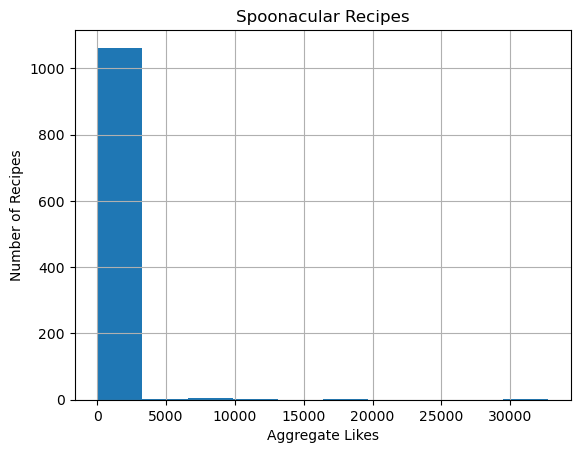

In [93]:
# Create a histogram of the Likes column
simplified_df['Likes'].hist(bins=10)
plt.title("Spoonacular Recipes")
plt.xlabel("Aggregate Likes")
plt.ylabel("Number of Recipes")
plt.show()

In [94]:
# Identify recipes with '0' likes
zero_likes = simplified_df.loc[simplified_df['Likes'] == 0].copy()
print(f'zero_likes: {zero_likes.shape}')

zero_likes: (15, 27)


### Separate Likes outliers from the dataset

Number of outliers: 153


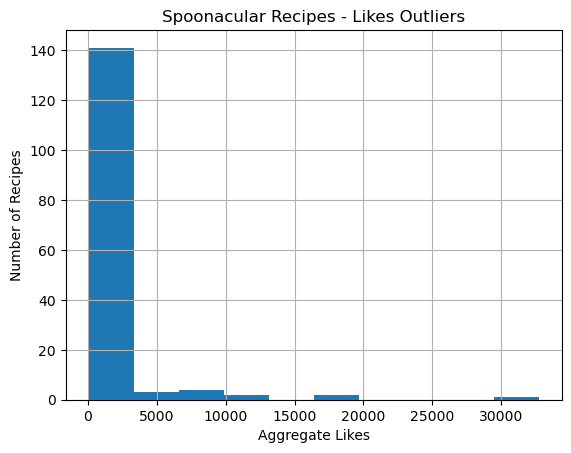

In [95]:
# Get the upper bounds for Likes
upper_likes = calc_stats.loc['upper_bounds', 'Likes']
likes_outliers = simplified_df.loc[simplified_df['Likes'] > upper_likes].copy()

# Display the count of outlier recipes
print(f"Number of outliers: {likes_outliers['Likes'].count()}")

# Create a histogram to understand distribution
likes_outliers['Likes'].hist(bins=10)
plt.title("Spoonacular Recipes - Likes Outliers")
plt.xlabel("Aggregate Likes")
plt.ylabel("Number of Recipes")
plt.show()

In [96]:
# Get the descriptive statistics for the outliers
outlier_stats = likes_outliers['Likes'].describe()
outlier_stats = add_iqr(outlier_stats)
print(outlier_stats)

# Get the DataFrame for outliers of outliers
outliers_squared = likes_outliers.loc[likes_outliers['Likes'] > outlier_stats['upper_bounds']]
print(f'outliers_squared: {outliers_squared.shape}')
outliers_squared.head()

count             153.000000
mean             1164.947712
std              3728.343608
min                43.000000
25%                61.000000
50%               122.000000
75%               396.000000
max             32767.000000
iqr               335.000000
lower_bounds     -441.500000
upper_bounds      898.500000
dtype: float64
outliers_squared: (26, 27)


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs),Carbohydrates,Cooking Minutes,Carbs (Amount),Carbs (Unit),Carbs (% of Daily Needs)
4,715562,Loaded Baked Potato Soup,5743,"['lunch', 'soup', 'main course', 'main dish', ...",[],9,24.0,623.73,kcal,31.19,...,mg,26.09,21.16,g,42.32,58g,35.0,58.00,g,19.33
74,775585,"Crockpot ""Refried"" Beans",13090,"['antipasti', 'starter', 'snack', 'appetizer',...",[],7,2.0,89.06,kcal,4.45,...,mg,19.35,5.40,g,10.79,16g,35.0,16.00,g,5.33
138,715424,The Best Chili,32767,"['lunch', 'soup', 'main course', 'main dish', ...",['American'],16,6.0,482.48,kcal,24.12,...,mg,30.93,57.75,g,115.49,35g,35.0,35.00,g,11.67
177,715455,Homemade Pecan Pie,7730,['dessert'],['Southern'],6,21.0,445.24,kcal,22.26,...,mg,7.90,4.90,g,9.80,66g,35.0,66.00,g,22.00
208,716431,Crockpot Applesauce,1703,"['antipasti', 'starter', 'snack', 'appetizer',...",[],5,1.0,412.45,kcal,20.62,...,mg,0.36,1.49,g,8.28,NaN,35.0,106.55,g,35.52


The r-value is: 0.5937404101848828


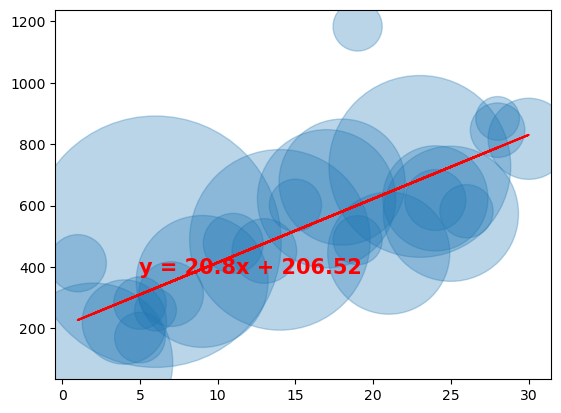

In [97]:
# Plot the relationship between outliers of outliers' WW Smart Points vs Likes
x_values = outliers_squared['WW Smart Points']
y_values = outliers_squared['Calories (Amount)']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values, s=outliers_squared['Likes'], alpha=0.3)
linreg_plot(ax, x_values, y_values, 100, 100)
plt.show()

Number of recipes within limits: 921


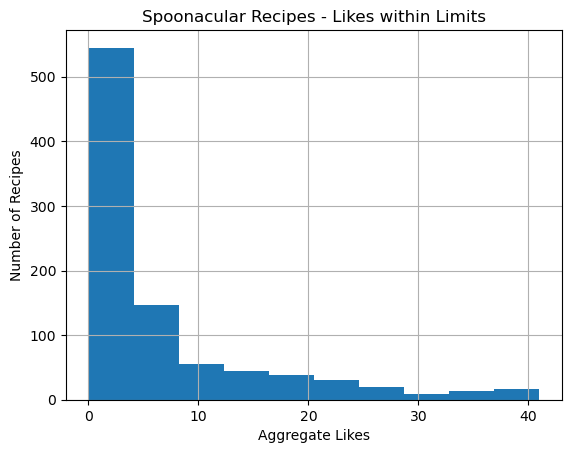

In [98]:
# Get Likes within the limits
likes_within = simplified_df.loc[simplified_df['Likes'] < upper_likes]

# Print the count of recipes within limits
print(f"Number of recipes within limits: {likes_within['Likes'].count()}")

# Create a histogram to understand distribution
likes_within['Likes'].hist(bins=10)
plt.title("Spoonacular Recipes - Likes within Limits")
plt.xlabel("Aggregate Likes")
plt.ylabel("Number of Recipes")
plt.show()

## Convert Spoonacular columns to Food.com equivalents

In [99]:
# Food.com columns
clean_recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'rating', 'meal_type', 'cuisine', 'Calories',
       'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)',
       'Saturated Fat (PDV)', 'Carbohydrates (PDV)', 'total_fat_g', 'sugar_g',
       'sodium_g', 'protein_g', 'sat_fat_g', 'carbs_g', 'wws_points'],
      dtype='object')

In [100]:
# Current Spoonacular data columns
simplified_df.columns

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates', 'Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)'],
      dtype='object')

### Convert Aggregate Likes to 5-point Star Rating

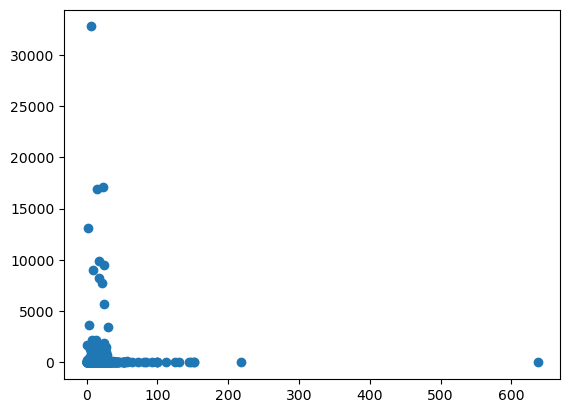

In [101]:
x_values = simplified_df['WW Smart Points']
y_values = simplified_df['Likes']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)

# CUTOFF

In [102]:
import numpy as np
points_bins = np.arange(-50, 105, 10)
bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins)
points_df = clean_recipes.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"
points_df

binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True)
binned_df

,id,minutes,contributor_id,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
WWS Point Ranges,,,,,,,,,,,,,,,,,,,,
"(-50, -40]",180747.000000,25.000000,2.396957e+05,5.666667,7.000000,4.904762,346.400000,11.333333,6.666667,14.333333,117.333333,11.666667,1.666667,7.366667,3.333333,0.344000,58.666667,2.333333,5.000000,-42.333333
"(-40, -30]",210598.557692,42.865385,2.314157e+05,9.942308,8.519231,4.535457,422.350000,30.057692,3.903846,22.134615,102.346154,32.653846,1.615385,19.537500,1.951923,0.531231,51.173077,6.530769,4.846154,-33.153846
"(-30, -20]",199073.661765,43.533088,2.383869e+05,10.330882,9.194853,4.563836,430.497794,33.014706,6.136029,22.680147,85.860294,36.404412,3.672794,21.459559,3.068015,0.544324,42.930147,7.280882,11.018382,-23.257353
"(-20, -10]",195749.360256,40.047436,2.808147e+06,10.242308,9.587179,4.575524,392.180513,30.793590,8.306410,24.856410,66.735897,35.553846,5.137179,20.015833,4.153205,0.596554,33.367949,7.110769,15.411538,-13.807692
"(-10, 0]",210396.679254,37.711422,5.413973e+06,10.188811,9.306760,4.600227,331.416783,26.754779,9.427972,24.177622,42.707226,33.866667,6.450816,17.390606,4.713986,0.580263,21.353613,6.773333,19.352448,-3.299767
"(0, 10]",213152.369649,35.778740,1.625415e+06,9.723906,8.919913,4.592606,265.240957,20.954786,11.083935,18.367003,22.493987,26.389851,7.369168,13.620611,5.541967,0.440808,11.246994,5.277970,22.107504,5.179413
"(10, 20]",214671.534926,37.895680,4.491914e+06,9.688879,9.575368,4.626128,317.395864,25.634191,24.116268,20.229779,22.352022,30.471507,9.572610,16.662224,12.058134,0.485515,11.176011,6.094301,28.717831,14.882812
"(20, 30]",215143.230553,38.590440,3.628200e+06,9.627929,9.537957,4.606360,310.614339,23.936270,39.563261,18.929709,19.965323,27.848172,10.119025,15.558575,19.781631,0.454313,9.982662,5.569634,30.357076,24.944705
"(30, 40]",218612.861685,36.570747,2.715428e+05,9.672496,9.030207,4.618666,300.178696,21.693164,55.214626,14.990461,17.758347,25.909380,10.581876,14.100556,27.607313,0.359771,8.879173,5.181876,31.745628,35.014308


The r-value is: 0.09515616190517066


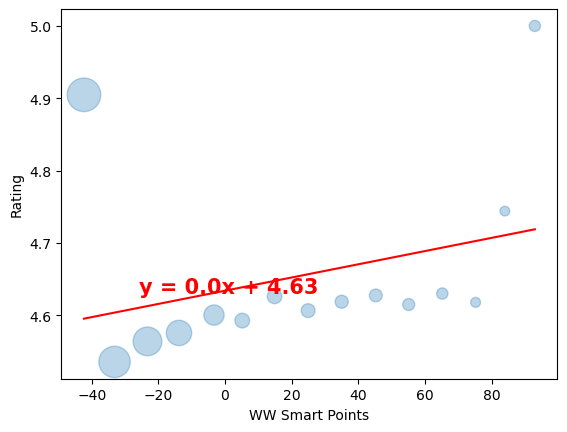

In [103]:
x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

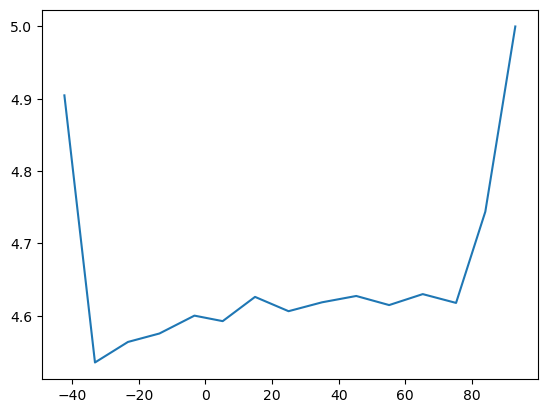

In [104]:
plt.plot(x_val, y_val)

In [105]:
binned_df['wws_points'].describe()

count    15.000000
mean     25.466953
std      43.676375
min     -42.333333
25%      -8.553730
50%      24.944705
75%      60.177650
max      93.000000
Name: wws_points, dtype: float64

In [106]:
# Check recipes <40 wws_points
low_points = clean_recipes.loc[clean_recipes['wws_points'] < -40]
low_points

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
9042,asian flavoured chicken burgers oamc,290232,15,506519,2008-03-05,"['lactose', '15-minutes-or-less', 'time-to-mak...","[375.6, 14.0, 5.0, 12.0, 114.0, 12.0, 3.0]",4,['place all ingredients in a bowl and mix unti...,light and freshly flavoured burgers. these are...,...,114.0,12.0,3.0,9.10,2.5,0.288,57.0,2.4,9.0,-41
78163,egyptian red snapper in red pepper mint sauce,133946,20,183964,2005-08-18,"['30-minutes-or-less', 'time-to-make', 'course...","[328.6, 9.0, 7.0, 5.0, 120.0, 5.0, 1.0]",4,"['saute onion in olive oil until golden', 'add...",this recipe is posted for the zaar world tour ...,...,120.0,5.0,1.0,5.85,3.5,0.120,60.0,1.0,3.0,-44
183106,simple salsa chicken,118063,40,28604,2005-04-19,"['60-minutes-or-less', 'time-to-make', 'course...","[335.0, 11.0, 8.0, 26.0, 118.0, 18.0, 1.0]",9,['spray a shallow baking dish with cooking spr...,"ok, so this can serve 10 people, if each perso...",...,118.0,18.0,1.0,7.15,4.0,0.624,59.0,3.6,3.0,-42


In [107]:
no_oamc = parse_tags(['oamc-freezer-make-ahead'], clean_recipes, 'id')
test_df = clean_recipes.loc[~clean_recipes['id'].isin(no_oamc['oamc-freezer-make-ahead']['id_list'])]
test_df

points_bins = np.arange(-40, 105, 10)
print(len(points_bins))
bins_df = pd.cut(test_df['wws_points'], bins=points_bins)
points_df = test_df.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"
points_df

binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True)
binned_df

x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

test1_df = clean_recipes.loc[clean_recipes['id'].isin(no_oamc['oamc-freezer-make-ahead']['id_list'])]
test1_df.describe()

TypeError: parse_tags() missing 1 required positional argument: 'save_col'

In [ ]:
# STATISTICAL TESTING and PLOTS
sample_set = clean_recipes['wws_points'].sample(n=500)
sample_set.hist(bins=15)

stats.shapiro(sample_set)

In [ ]:
result = stats.anderson(clean_recipes['wws_points'])

print('Statistic: %.3f' % result.statistic)
p = 0
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

In [ ]:
# Parse the ingredients column
# Identify how to isolate each tag
tag_string = clean_recipes['ingredients'][1].strip("[]")
tag_string = tag_string.split(', ')
tag_string[0].strip("'")

# Get a list of unique tags
unique_ingredients = []
for string in clean_recipes['ingredients']:
    # Strip and split the string to a list
    tag_list = string.strip("[]").split(', ')
    for word_idx in range(len(tag_list)):
        # Get the tag
        tag = tag_list[word_idx].strip("'")
        if tag not in unique_ingredients:
            unique_ingredients.append(tag)

# Display the tags alphabetically
print(f"Number of unique ingredients: {len(unique_ingredients)}")

sorted_ingredients = sorted(unique_ingredients)
sorted_ingredients

for row in range(0, 52):
    sorted_ingredients[row] = sorted_ingredients[row].strip('"')
sorted_ingredients

# open file
with open('ingredients_commas.txt', 'w+') as f:
     
    # write elements of list
    for items in sorted_ingredients:
        f.write('%s, ' %items)
    print("File written successfully")
 
 
# close the file
f.close()
# # for line in sorted_ingredients[0:52]:
# #     print(line.strip('"'))
# sorted = [line.strip('"') for line in unique_ingredients[0:52]]
# unique_ingredients[0:52]

In [ ]:
import food
report = food.get_report()
report[32]['Description']

In [ ]:
categories = []
for row in range(len(report)):
    categories.append(report[row]['Category'])

new_data = set(categories)
old_data = set(sorted_ingredients)

# if (new_data & old_data):
#     print(new_data & old_data)
if len(new_data.intersection(old_data)) > 0:
    print(new_data.intersection(old_data))
else:
    print("no common elements")
new_data = set([word.lower() for word in list(new_data)])
old_data = set([word.lower() for word in list(old_data)])

if len(new_data.intersection(old_data)) > 0:
    intersect = new_data.intersection(old_data)
    print(len(intersect))
    print(intersect)
else:
    print("no common elements")

# Return dataframe with these common ingredients


In [ ]:
# Recipes with negative points are high in protein
negative_points = clean_recipes.loc[clean_recipes['wws_points'] < 0].copy()
print(f'negative_points: {negative_points.shape}')
negative_points.head()

In [ ]:
x_values = negative_points['wws_points']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['total_fat_g']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['Calories']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['wws_points']
y_values = negative_points['carbs_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['Calories']
y_values = negative_points['carbs_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
recipe_sample = clean_recipes.sample(n=500)
x_values = recipe_sample['wws_points']
y_values = recipe_sample['rating']

fig_test, ax_test = plt.subplots()
ax_test.scatter(x_values, y_values)
linreg_plot(ax_test, x_values, y_values, 80, 80)

In [ ]:
# CREATE A BUBBLE PLOT? Bin the WW Smart Points, use the count of each bin as the bubble size (and plot this as the 3rd dimension)

##